---
>「みんなジャズが好きって言うけど、実際は“ジャズのイメージ”が好きなんだよ。」 \
>（セブ:映画 La La Land より）
---

# Transformer実践編 - 日英翻訳モデルの構築

**日本語⇔英語の機械翻訳モデル**を一から構築する

論文「Attention Is All You Need (Vaswani et al., NeurIPS 2017)」で提案された Transformer アーキテクチャを実装し、その内容を理解する


## 全体の流れ

1. **環境設定**  
   - PyTorch / sentencepiece / tqdm など必要ライブラリのインストールとインポート

1. **データセットの準備**  
   - 公開の日英対訳コーパスをダウンロード・読み込みし、前処理を行う

1. **SentencePiece によるサブワードトークナイザ学習**  
   - 日本語・英語それぞれに対して SentencePiece モデルを学習し、系列長や OOV 問題を緩和する

1. **PyTorch Dataset / DataLoader の定義**  
   - Transformer に入力できるよう、トークン列をテンソルへ変換するクラスを実装

1. **Transformer モデル構築**  
   - 位置エンコーディング、マスク生成、エンコーダ・デコーダブロック等を実装

1. **学習ユーティリティ**  
   - Noam スケジューラ（学習率スケジューラ）や損失関数、学習ループを定義し、学習の可視化（損失曲線など）を行う

1. **推論・評価・可視化**  
   - 学習済みモデルを用いて翻訳を行い、BLEU スコアで定量評価  
   - Attention をヒートマップとして可視化し、モデルがどの単語に注目しているかを観察する

## 環境設定

**ライブラリのインストールとインポート、乱数シードの固定、GPU 利用設定** を行う

- `pip` による追加パッケージのインストール（必要な場合）  
- `torch`, `torch.nn`, `torch.optim`, `torch.utils.data` など PyTorch の基本モジュール  
- `sentencepiece` によるサブワードトークナイザ  
- `tqdm` によるプログレスバー表示  
- `matplotlib` による学習曲線や Attention の可視化

In [1]:
# 必要なライブラリのインストール
!pip install sentencepiece sacrebleu -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 5.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sentencepiece as spm
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import urllib.request
import warnings
from tqdm.auto import tqdm
import sacrebleu

warnings.filterwarnings('ignore')

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch Version: {torch.__version__}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# シード設定
torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.9.0+cu126
Using device: cuda
GPU: Tesla T4


## データセットのダウンロードと準備

**日英対訳データを取得して学習に使える形へ整形** する

- 公開コーパス（例：TED, Tatoeba, JParaCrawl などの一部）を HTTP 経由でダウンロード
- 圧縮ファイルであれば解凍し、日本語と英語の対訳ペアを行単位で読み込む
- ノイズ除去・前処理  
  - 空行の除去  
  - 文字数が極端に短い／長い文のフィルタリング  
  - 不正な文字や制御文字の除去 など

最終的に、

```python
pairs = [(src_sentence_ja, tgt_sentence_en), ...]
```

の形で **日本語→英語の対訳ペアのリスト**を獲得する

この `pairs` が以降のトークナイザ学習・モデル学習の共通入力となる

In [3]:
# データセットのダウンロード
def download_dataset():
    """small_parallel_enja データセットをダウンロード"""

    base_url = "https://raw.githubusercontent.com/odashi/small_parallel_enja/master/"

    files = {
        'train.en': 'train.en',
        'train.ja': 'train.ja',
        'dev.en': 'dev.en',
        'dev.ja': 'dev.ja',
        'test.en': 'test.en',
        'test.ja': 'test.ja',
    }

    os.makedirs('data', exist_ok=True)

    for local_name, remote_name in files.items():
        local_path = f'data/{local_name}'
        if not os.path.exists(local_path):
            url = base_url + remote_name
            print(f"Downloading {remote_name}...")
            urllib.request.urlretrieve(url, local_path)

    print("✅ データセットのダウンロード完了")

download_dataset()

✅ データセットのダウンロード完了


### データの読み込みと概要表示

ダウンロードした対訳データセットをメモリに読み込み、その内容をPythonのリスト形式で扱えるように整形する

- `load_data(split='train')` 関数:
  - 引数 `split` に応じて（例: 'train', 'dev', 'test'）、対応する英語 (`.en`) と日本語 (`.ja`) のファイルを読み込む
  - 各ファイルの行を読み込み、前後の空白を除去 (`strip()`) してからリストに格納する
  - 最後に `zip()` 関数を使って、英語の行と日本語の行をペアにして、`(英語の文, 日本語の文)` のタプルのリストとして返す

- データセットの分割:
  - `load_data` 関数を使って、`train_pairs`（訓練データ）、`dev_pairs`（検証データ）、`test_pairs`（テストデータ）の3つのリストを作成する

- データセットサイズの表示:
  - `len()` 関数を使って、各データセットに含まれる対訳ペアの総数を表示する
  - モデルがどれくらいのデータで学習・評価されるのかを把握するために重要

- サンプルの表示:
  - 読み込まれたデータの中から最初の5つの対訳ペアを表示する
  - データが正しく読み込まれ、どのような形式になっているかを目視で確認する

In [4]:
# データの読み込み
def load_data(split='train'):
    """データを読み込んでペアのリストを返す"""
    with open(f'data/{split}.en', 'r', encoding='utf-8') as f:
        en_lines = [line.strip() for line in f]
    with open(f'data/{split}.ja', 'r', encoding='utf-8') as f:
        ja_lines = [line.strip() for line in f]

    return list(zip(en_lines, ja_lines))

# データの読み込み
train_pairs = load_data('train')
dev_pairs = load_data('dev')
test_pairs = load_data('test')

print(f"データセットサイズ:")
print(f"  訓練: {len(train_pairs):,} 文対")
print(f"  検証: {len(dev_pairs):,} 文対")
print(f"  テスト: {len(test_pairs):,} 文対")

print("\nサンプル:")
for i in range(5):
    en, ja = train_pairs[i]
    print(f"  EN: {en}")
    print(f"  JA: {ja}")
    print()

データセットサイズ:
  訓練: 50,000 文対
  検証: 500 文対
  テスト: 500 文対

サンプル:
  EN: i can 't tell who will arrive first .
  JA: 誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。

  EN: many animals have been destroyed by men .
  JA: 多く の 動物 が 人間 に よ っ て 滅ぼ さ れ た 。

  EN: i 'm in the tennis club .
  JA: 私 は テニス 部員 で す 。

  EN: emi looks happy .
  JA: エミ は 幸せ そう に 見え ま す 。

  EN: please bear this fact in mind .
  JA: この 事実 を 心 に 留め て お い て 下さ い 。



### 文長分布の可視化

`train_pairs` に含まれる文の長さ（英語・日本語）をざっと確認する

- 極端に長い文がどの程度含まれているか
- バッチ内の系列長のバラつきがどの程度か

といった点を感覚的に把握する

ここでは簡単のため、英語は「空白区切りの単語数」、日本語は「文字数」でヒストグラムを描画する


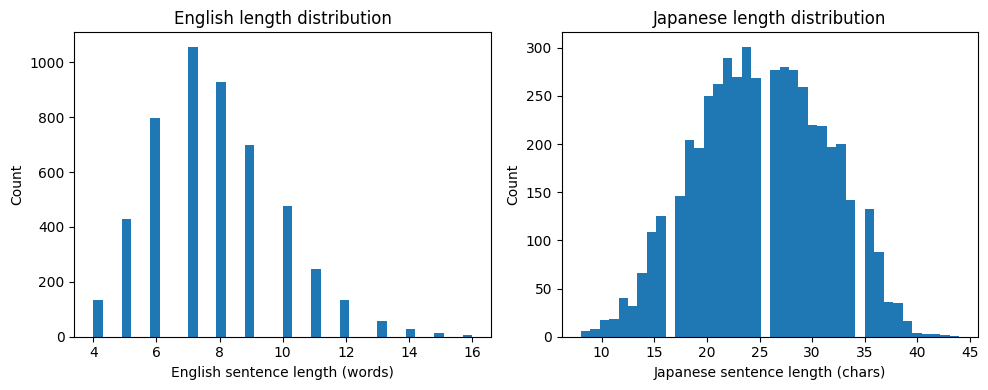

In [5]:
# 文長分布の可視化（訓練データの一部を使用）
max_samples = 5000  # 計算コストを抑えるために上限を設定
subset = train_pairs[:max_samples]

en_lengths = [len(en.split()) for en, ja in subset]
ja_lengths = [len(ja) for en, ja in subset]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(en_lengths, bins=40)
plt.xlabel('English sentence length (words)')
plt.ylabel('Count')
plt.title('English length distribution')

plt.subplot(1, 2, 2)
plt.hist(ja_lengths, bins=40)
plt.xlabel('Japanese sentence length (chars)')
plt.ylabel('Count')
plt.title('Japanese length distribution')

plt.tight_layout()
plt.show()


## SentencePiece トークナイザーの訓練

ここでは **SentencePiece** を用いて、日本語と英語の **サブワードトークナイザ** を学習する

### なぜサブワードか？

- 単語単位の分かち書きでは、未知語（OOV）が多くなりがち
- 文字単位では系列が極端に長くなり、学習効率が悪い  
→ その中間として、**サブワード単位**でトークナイズする手法が利用される

### コード

- `train_sentencepiece(pairs, prefix, vocab_size=8000)`  
  - 対訳ペアから対象言語の文のみを抽出してファイルに書き出す
  - SentencePiece のトレーナを呼び出し、指定語彙数 `vocab_size` でモデルを学習
  - `prefix.model`, `prefix.vocab` といったファイルとして保存

- 学習済み SentencePiece モデルの読み込み  
  - `spm.SentencePieceProcessor()` を用いて `sp_ja` / `sp_en` のようなトークナイザインスタンスを作成

- トークナイズのデモ  
  - 実際に任意の日本語／英語文をトークナイズして、
    - サブワード列
    - 対応する ID 列  
    を表示し、**モデルがどのような単位で文を分割しているか**を確認します。

この部分で「語彙の大きさ」「サブワード分割の傾向」をある程度把握しておくと、後続のモデルの挙動が理解しやすくなる

### character_coverage

character_coverage は、学習データに含まれる全文字のうち、どれだけの割合を語彙として登録するかを決めるパラメータ

なぜ日本語だけ少し低くするのか？

- 文字種の多さ: 英語はアルファベットと記号で種類が限られていますが、日本語は数千種類の「漢字」が含まれる

- 稀な文字の排除: 漢字の中には、データセット全体で1回しか出てこないような極めて稀な文字や、Webデータのノイズ（絵文字や特殊記号など）が含まれることがある

- 効率化: これら全ての文字をカバーしようとすると（1.0にすると）、それだけで貴重な語彙サイズを消費するため、0.9995（99.95%）に設定することで、出現頻度の極端に低い「ロングテール」の文字（残り0.05%）を <unk>（未知語）として切り捨て、その分をより頻出する単語やサブワードの表現に割り当てることができる

これは、漢字を使用する言語（日本語や中国語）で SentencePiece を学習させる際の一般的なテクニックである

In [6]:
def train_sentencepiece(pairs, prefix, vocab_size=8000):
    """
    SentencePieceモデルを訓練

    Args:
        pairs: (英語, 日本語) のペアのリスト
        prefix: 出力ファイルのプレフィックス
        vocab_size: 語彙サイズ
    """
    # 英語と日本語を別々のファイルに保存
    os.makedirs('spm_models', exist_ok=True)

    # 英語
    with open('spm_models/train_en.txt', 'w', encoding='utf-8') as f:
        for en, _ in pairs:
            f.write(en + '\n')

    # 日本語
    with open('spm_models/train_ja.txt', 'w', encoding='utf-8') as f:
        for _, ja in pairs:
            f.write(ja + '\n')

    # SentencePieceモデルの訓練
    # 英語モデル
    if not os.path.exists(f'spm_models/{prefix}_en.model'):
        print("訓練中: 英語SentencePieceモデル...")
        spm.SentencePieceTrainer.train(
            input='spm_models/train_en.txt',
            model_prefix=f'spm_models/{prefix}_en',
            vocab_size=vocab_size,
            character_coverage=1.0,
            model_type='bpe',  # Byte Pair Encoding
            pad_id=0,
            unk_id=1,
            bos_id=2,
            eos_id=3,
        )

    # 日本語モデル
    if not os.path.exists(f'spm_models/{prefix}_ja.model'):
        print("訓練中: 日本語SentencePieceモデル...")
        spm.SentencePieceTrainer.train(
            input='spm_models/train_ja.txt',
            model_prefix=f'spm_models/{prefix}_ja',
            vocab_size=vocab_size,
            character_coverage=0.9995,  # 日本語は少し低めに
            model_type='bpe',
            pad_id=0,
            unk_id=1,
            bos_id=2,
            eos_id=3,
        )

    print("SentencePieceモデルの訓練完了")

# 訓練実行
train_sentencepiece(train_pairs, 'translator', vocab_size=8000)

訓練中: 英語SentencePieceモデル...
訓練中: 日本語SentencePieceモデル...
SentencePieceモデルの訓練完了


### SentencePiece モデルの読み込みと特殊トークンの確認

このセルでは、前のステップで訓練した SentencePiece モデルを読み込み、今後のトークン化処理で使用できるように準備する

- `spm.SentencePieceProcessor()`: SentencePiece モデルをロードするためのインスタンスを作成
- `sp_en.load('spm_models/translator_en.model')`: 英語の SentencePiece モデルファイルを読み込み
- `sp_ja.load('spm_models/translator_ja.model')`: 日本語の SentencePiece モデルファイルを読み込み

モデルがロードされると、以下の情報が表示される
- **英語語彙サイズ / 日本語語彙サイズ**: 各言語のサブワード語彙の総数を表時（このサイズは、モデルの埋め込み層のサイズに影響する）
- **特殊トークン**: Transformer モデルの学習において重要な役割を果たす特殊トークンとそのID（整数値）を定義・表示
  - `PAD_ID (0)`: パディングトークン、系列長を揃えるために使用され、Attention計算では無視される
  - `UNK_ID (1)`: 未知語トークン、語彙にない単語を表す
  - `BOS_ID (2)`: 文頭トークン（Beginning Of Sentence）、デコーダの入力の先頭に付与される
  - `EOS_ID (3)`: 文末トークン（End Of Sentence）、文の終わりを示しデコーダの生成停止条件となる

In [7]:
# SentencePieceモデルの読み込み
sp_en = spm.SentencePieceProcessor()
sp_ja = spm.SentencePieceProcessor()
sp_en.load('spm_models/translator_en.model')
sp_ja.load('spm_models/translator_ja.model')

print(f"英語語彙サイズ: {sp_en.get_piece_size()}")
print(f"日本語語彙サイズ: {sp_ja.get_piece_size()}")

# 特殊トークンのID
PAD_ID = 0
UNK_ID = 1
BOS_ID = 2
EOS_ID = 3

print(f"\n特殊トークン:")
print(f"  PAD: {PAD_ID} ({sp_en.id_to_piece(PAD_ID)})")
print(f"  UNK: {UNK_ID} ({sp_en.id_to_piece(UNK_ID)})")
print(f"  BOS: {BOS_ID} ({sp_en.id_to_piece(BOS_ID)})")
print(f"  EOS: {EOS_ID} ({sp_en.id_to_piece(EOS_ID)})")

英語語彙サイズ: 8000
日本語語彙サイズ: 8000

特殊トークン:
  PAD: 0 (<pad>)
  UNK: 1 (<unk>)
  BOS: 2 (<s>)
  EOS: 3 (</s>)


### トークナイゼーションのデモ

学習済みの SentencePiece モデルを使って、実際の文章がどのようにトークン化（分割）され、ID列に変換されるかを確認する

- `demo_tokenization()` 関数:
  - 英語と日本語のいくつかの例文リスト (`en_examples`, `ja_examples`) を定義する
  - 各例文に対して以下の処理を行い、結果を表示します。
    - `encode_as_pieces(text)`: テキストをサブワード（部分語）のリストに分割し、単語の先頭にはアンダースコア（実際の表示は ` ` ブロック文字など）を付与する
    - `encode_as_ids(text)`: テキストを語彙辞書に基づいた整数の ID 列に変換し、モデルへの実際の入力データとする

このデモを通じて、「unbelievable」のような長い単語が `['un', 'bel', 'ie', 'vable']` のように意味のある単位で分割されているか、日本語の文が適切に分かち書きされているかを確認できます。

In [8]:
# トークナイズのデモ
def demo_tokenization():
    print("=" * 60)
    print("SentencePiece トークナイゼーションのデモ")
    print("=" * 60)

    en_examples = [
        "i am a student",
        "he is playing basketball",
        "unbelievable performance"
    ]

    ja_examples = [
        "私は学生です",
        "彼はバスケットボールをしています",
        "信じられないパフォーマンス"
    ]

    print("\n🇬🇧 英語:")
    for text in en_examples:
        pieces = sp_en.encode_as_pieces(text)
        ids = sp_en.encode_as_ids(text)
        print(f"  原文: {text}")
        print(f"  サブワード: {pieces}")
        print(f"  ID: {ids}")
        print()

    print("🇯🇵 日本語:")
    for text in ja_examples:
        pieces = sp_ja.encode_as_pieces(text)
        ids = sp_ja.encode_as_ids(text)
        print(f"  原文: {text}")
        print(f"  サブワード: {pieces}")
        print(f"  ID: {ids}")
        print()

demo_tokenization()

SentencePiece トークナイゼーションのデモ

🇬🇧 英語:
  原文: i am a student
  サブワード: ['▁i', '▁am', '▁a', '▁student']
  ID: [7, 170, 8, 440]

  原文: he is playing basketball
  サブワード: ['▁he', '▁is', '▁playing', '▁basketball']
  ID: [19, 32, 858, 3862]

  原文: unbelievable performance
  サブワード: ['▁unb', 'el', 'ie', 'vable', '▁performance']
  ID: [4867, 370, 356, 5696, 5464]

🇯🇵 日本語:
  原文: 私は学生です
  サブワード: ['▁私', 'は', '学', '生', 'で', 'す']
  ID: [20, 6509, 6588, 6572, 6519, 6522]

  原文: 彼はバスケットボールをしています
  サブワード: ['▁彼', 'は', 'バ', 'ス', 'ケット', 'ボール', 'を', 'して', 'いま', 'す']
  ID: [11, 6509, 6659, 6569, 1273, 1764, 6516, 402, 2806, 6522]

  原文: 信じられないパフォーマンス
  サブワード: ['▁信じ', 'ら', 'れ', 'な', 'い', 'パ', 'フ', 'ォ', 'ーマ', 'ンス']
  ID: [1538, 6534, 6532, 6514, 6510, 6679, 6765, 7714, 2137, 3032]



## データセットクラス


### **`TranslationDataset` クラス**

Transformer に入力するためには、**トークン列を PyTorch テンソルへ変換する仕組み**が必要であり、`torch.utils.data.Dataset` を継承して、翻訳用データセットクラスを定義する

### このクラスで行っていること

- `__init__`  
  - 元の対訳ペア `pairs` と、学習済みトークナイザ `sp_src`, `sp_tgt`、最大系列長などを受け取り、内部に保持

- `__len__`  
  - データペア数を返し、`len(dataset)` でサンプル数が取得できるようにする

- `__getitem__(idx)`: インデックスに対応する対訳ペアを取得し、SentencePieceでトークン化（ID化）  
  - `idx` 番目の (src, tgt) 文字列ペアを取り出す
  - トークナイザで subword ID 列に変換
  - `<bos>`, `<eos>`, `<pad>` などの特殊トークンを付与、、指定された `max_len` に収まるように切り詰める
  - 固定長になるようにパディングし、`torch.LongTensor` に変換して返す
  - さらに、ソースマスク・ターゲットマスクなど、Transformer が必要とするマスクを生成

### マスクの扱い
- PAD トークンの位置を 0/1 マスクで表現し、Self-Attention が PAD に注意を向けないようにする
- Decoder 側では、未来のトークンを見ないように **"未来情報禁止" マスク**（look-ahead mask）も生成

### **`collate_fn` 関数**
- `DataLoader` が複数のサンプルを1つのバッチにまとめる際に呼び出される
- **パディング処理**: バッチ内の各文の長さは異なるため、`nn.utils.rnn.pad_sequence` を使って、バッチ内で最も長い文に合わせて短い文の末尾を `PAD_ID` で埋める
- これにより、バッチ全体を `[batch_size, seq_len]` の形状を持つ1つのテンソルとして扱えるようになる

In [9]:
class TranslationDataset(Dataset):
    """
    翻訳用データセット

    英語 → 日本語の翻訳タスク用にデータを準備します。
    """

    def __init__(self, pairs, sp_src, sp_tgt, max_len=64):
        """
        Args:
            pairs: (英語, 日本語) のペアのリスト
            sp_src: ソース言語のSentencePieceモデル
            sp_tgt: ターゲット言語のSentencePieceモデル
            max_len: 最大系列長
        """
        self.pairs = pairs
        self.sp_src = sp_src
        self.sp_tgt = sp_tgt
        self.max_len = max_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src_text, tgt_text = self.pairs[idx]

        # SentencePieceでエンコード（BOS/EOSを追加）
        src_ids = [BOS_ID] + self.sp_src.encode_as_ids(src_text) + [EOS_ID]
        tgt_ids = [BOS_ID] + self.sp_tgt.encode_as_ids(tgt_text) + [EOS_ID]

        # 最大長でカット
        src_ids = src_ids[:self.max_len]
        tgt_ids = tgt_ids[:self.max_len]

        return {
            'src': torch.tensor(src_ids, dtype=torch.long),
            'tgt': torch.tensor(tgt_ids, dtype=torch.long),
            'src_text': src_text,
            'tgt_text': tgt_text
        }


def collate_fn(batch):
    """バッチ内のデータをパディング"""
    src_tensors = [item['src'] for item in batch]
    tgt_tensors = [item['tgt'] for item in batch]

    src_padded = nn.utils.rnn.pad_sequence(src_tensors, batch_first=True, padding_value=PAD_ID)
    tgt_padded = nn.utils.rnn.pad_sequence(tgt_tensors, batch_first=True, padding_value=PAD_ID)

    return {
        'src': src_padded,
        'tgt': tgt_padded,
        'src_texts': [item['src_text'] for item in batch],
        'tgt_texts': [item['tgt_text'] for item in batch]
    }


# データセットとDataLoaderの作成
train_dataset = TranslationDataset(train_pairs, sp_en, sp_ja)
dev_dataset = TranslationDataset(dev_pairs, sp_en, sp_ja)
test_dataset = TranslationDataset(test_pairs, sp_en, sp_ja)

print(f"データセット作成完了")
print(f"  訓練: {len(train_dataset)} サンプル")
print(f"  検証: {len(dev_dataset)} サンプル")
print(f"  テスト: {len(test_dataset)} サンプル")

データセット作成完了
  訓練: 50000 サンプル
  検証: 500 サンプル
  テスト: 500 サンプル


## Transformerモデルの実装

ここでは、論文「Attention Is All You Need」で提案された **Transformer アーキテクチャ**を、PyTorch で実装します。

### 主な構成要素

- **埋め込み層 (Embedding)**  
  - トークン ID を連続ベクトルに写像

- **位置エンコーディング (PositionalEncoding)**  
  - Self-Attention 自体には系列順序の情報がないため、
    - `sin` / `cos` を用いた連続的な位置表現を加算して、系列内の相対位置を表現
  - このノートブックでは、オリジナル論文と同様の **正弦波型位置エンコーディング**を実装

- **マルチヘッド・アテンション (Multi-Head Attention)**  
  - 入力ベクトルから Query / Key / Value を線形変換して計算
  - 複数のヘッドが異なるサブ空間に注目することで、
    - 文法構造
    - 語彙的対応  
    など、多様な関係を同時に捉える

- **Position-wise Feed-Forward Network**  
  - 各位置ごとに同じ 2 層 MLP を適用して非線形変換を行う

- **エンコーダ・デコーダブロック**  
  - エンコーダ層: Self-Attention → FFN （＋Residual & LayerNorm）を複数層スタック  
  - デコーダ層: Masked Self-Attention → Encoder-Decoder Attention → FFN を複数層スタック

### 実装上のポイント

- パディング位置を -inf に置き換えた上で softmax を計算することで、Attention が PAD を無視するようにしている
- `nn.Transformer` をそのまま使うのではなく、基礎理解のために **自前実装**している（セル内コードを参照）

このセクションのコードセルでは、上記コンポーネントがクラスとして順次定義され、最後にエンドツーエンドの `Transformer` モデルとして組み上げられます。


In [10]:
class PositionalEncoding(nn.Module):
    """位置エンコーディング"""

    def __init__(self, d_model: int, max_seq_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

### 入力埋め込みと位置エンコーディング (Positional Encoding)

#### なぜ位置エンコーディングが必要なのか？

RNNは単語を順番に処理するため、自然に位置情報を持っています。
しかし、Transformerは全ての単語を**並列に**処理するため、単語の順序情報が失われてしまいます。

例えば：
- 「猫が犬を追いかける」
- 「犬が猫を追いかける」

この2つの文は、単語の集合としては同じですが、意味は全く異なります。
**位置エンコーディング**によって、各単語の位置情報をモデルに伝えます。

#### 数式

位置 $pos$ と次元 $i$ に対して：

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

- $pos$: 系列内での位置 (0, 1, 2, ...)
- $i$: 次元のインデックス
- $d_{model}$: モデルの次元数（例：512）

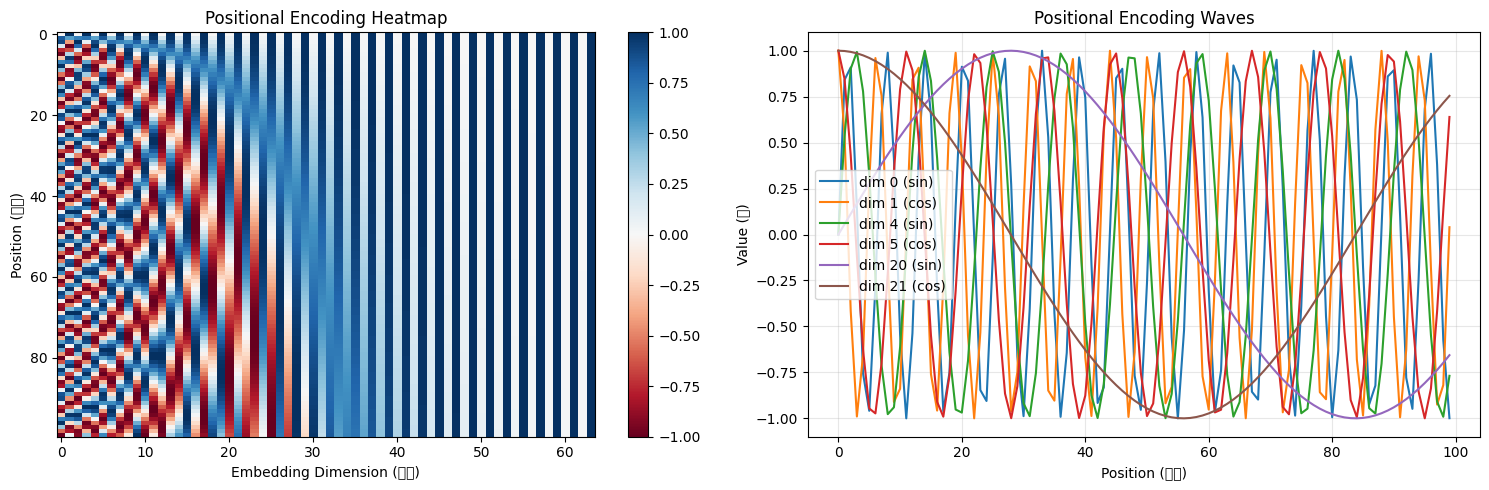


解説:
- 低い次元(dim 0, 1): 高周波の波 → 近い位置の区別に有効
- 高い次元(dim 20, 21): 低周波の波 → 遠い位置の大まかな区別に有効
- 各位置は固有のパターンを持つため、モデルは位置を識別できる


In [11]:
# 位置エンコーディングの可視化
def visualize_positional_encoding():
    """
    位置エンコーディングがどのようなパターンを持つか可視化します。
    各位置で異なるパターンが生成されることを確認できます。
    """
    d_model = 64
    max_len = 100

    pe = PositionalEncoding(d_model, max_len, dropout=0.0)

    # ダミー入力（全てゼロ）を通して位置エンコーディングを取得
    dummy_input = torch.zeros(1, max_len, d_model)
    pe_output = pe(dummy_input)

    plt.figure(figsize=(15, 5))

    # ヒートマップ
    plt.subplot(1, 2, 1)
    plt.imshow(pe_output[0].numpy(), aspect='auto', cmap='RdBu')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    plt.title('Positional Encoding Heatmap')
    plt.colorbar()

    # 特定の次元での波形
    plt.subplot(1, 2, 2)
    positions = range(max_len)
    for dim in [0, 1, 4, 5, 20, 21]:
        plt.plot(positions, pe_output[0, :, dim].numpy(),
                 label=f'dim {dim} ({"sin" if dim % 2 == 0 else "cos"})')
    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.title('Positional Encoding Waves')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n解説:")
    print("- 低い次元(dim 0, 1): 高周波の波 → 近い位置の区別に有効")
    print("- 高い次元(dim 20, 21): 低周波の波 → 遠い位置の大まかな区別に有効")
    print("- 各位置は固有のパターンを持つため、モデルは位置を識別できる")

visualize_positional_encoding()

## Transformer と Dropout

TransformerではDropoutは必要という考えがあり、Batch Normalization (BN) よりもLayer Normalization (LN) + Dropoutの組み合わせが適しているとされている

### なぜBNではなくLN + Dropoutなのか
- Batch Normalizationの問題点（系列データにおいて）

問題 | 説明
--- | ---
可変長系 | 列BNはバッチ方向で統計量を計算するが、<br>系列長が異なると各位置での統計量が不安定になる
バッチサイズ依存 | 小さいバッチサイズで性能が劣化する
推論時の不一致 | 学習時と推論時で挙動が異なる(running mean/var の問題)
パディングの影響 | PADトークンが統計量を歪める

```
BNの計算方向:
バッチ
  ↓
[文1] token1 token2 token3 PAD   PAD
[文2] token1 token2 PAD    PAD   PAD   ← 同じ位置でも意味が異なる
[文3] token1 token2 token3 token4 token5
  ↓
位置ごとにバッチ方向で正規化 → 不安定
```

- Layer Normalizationが適している理由

```
LNの計算方向:
[文1] token1 token2 token3 PAD   PAD   → 各文の特徴次元で正規化
                    ←――――――――――→
```
  - バッチサイズに依存しない（各サンプル独立）
  - 可変長系列に対応
  - 学習時と推論時で同じ挙動

- DropoutとLNは役割が異なる
  - Layer Normalization=学習の安定化、勾配の流れを改善
  - Dropout=過学習の防止（正則化）

つまり、
- ** 可変長系列・自己回帰生成においてBNは不適切 **
- ** BNは「正規化 + 正則化効果」を持つが、LNは正則化効果が弱いため、Dropoutが別途必要 **
- Transformerにおいて、LN + Dropoutは標準的かつ適切な選択

実験的な検証が実施されている 論文: "On Layer Normalization in the Transformer Architecture" (Xiong et al., 2020)



### Multi-Head Attention の実装

Transformerの中核となる **Multi-Head Attention** 機構を実装する

1. **線形変換**: 入力された Query, Key, Value をそれぞれ `n_heads` 個のサブ空間に射影する
1. **Scaled Dot-Product Attention**:
   - $Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$
   - Query と Key の内積を取り、スケーリングしてから Softmax を適用して重みを計算する
   - マスクがある場合（パディングや未来のトークン隠し）、対応するスコアを $-\infty$ にして無視する
1. **結合と出力**: 各ヘッドの出力を結合（Concat）し、最後に線形層を通して元の次元に戻す

In [12]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention"""

    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.attention_weights = None

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        Q = self.W_q(query).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        self.attention_weights = F.softmax(scores, dim=-1)
        attn_output = self.dropout(self.attention_weights)
        attn_output = torch.matmul(attn_output, V)

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(attn_output)

### Position-wise Feed-Forward Networks

各位置のトークンに対して独立に適用される全結合ニューラルネットワーク

$$FFN(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

2層の線形変換と、その間の ReLU 活性化関数で構成

「Position-wise」とは、系列内のどの位置（単語）に対しても同じ重みパラメータを使って計算を行うことを意味する

In [13]:
class PositionwiseFeedForward(nn.Module):
    """Position-wise Feed Forward Network"""

    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

### Encoder Layer

エンコーダの1層分を定義する

以下の2つのサブレイヤーで構成されます。

1. **Self-Attention**: 入力系列内の単語間の関係を捉える
1. **Feed-Forward**: 各単語の特徴を非線形変換する

また、各サブレイヤーの前後には **Residual Connection (残差結合)** と **Layer Normalization** が適用される

ここでは、学習の安定性を高めるために **Pre-LayerNorm**（SubLayerの入力前に正規化を行う構成）を採用する

In [14]:
class EncoderLayer(nn.Module):
    """Encoder Layer"""

    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Pre-LN: LayerNorm → SubLayer → Residual
        attn_out = self.self_attn(self.norm1(x), self.norm1(x), self.norm1(x), mask)
        x = x + self.dropout(attn_out)

        ff_out = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ff_out)

        return x

### Decoder Layer

デコーダの1層分を定義する

エンコーダと異なり、3つのサブレイヤーを持る

1. **Masked Self-Attention**: 生成済みの単語のみに注目するように、未来の単語をマスクした Self-Attention
1. **Cross-Attention (Encoder-Decoder Attention)**: Query をデコーダ側から、Key/Value をエンコーダの出力から受け取り、ソース文の情報を取得する
1. **Feed-Forward**: エンコーダと同様の全結合層

In [15]:
class DecoderLayer(nn.Module):
    """Decoder Layer"""

    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        # Masked Self-Attention
        self_attn_out = self.self_attn(self.norm1(x), self.norm1(x), self.norm1(x), tgt_mask)
        x = x + self.dropout(self_attn_out)

        # Cross-Attention
        cross_attn_out = self.cross_attn(self.norm2(x), encoder_output, encoder_output, src_mask)
        x = x + self.dropout(cross_attn_out)

        # Feed Forward
        ff_out = self.feed_forward(self.norm3(x))
        x = x + self.dropout(ff_out)

        return x

### Transformer モデル全体

これまでに定義したコンポーネントを組み合わせて、完全な Transformer モデルを構築する

- **Embedding & Positional Encoding**: 入力IDをベクトル化し、位置情報を加算する
- **Encoder / Decoder Stacks**: 指定された層数 (`n_encoder_layers`, `n_decoder_layers`) だけレイヤーを積み重ねる
- **Output Linear**: デコーダの出力を語彙サイズ次元のロジットに変換する
- **Mask Creation**: パディングトークンを無視するためのマスクと、デコーダで未来の情報を隠すためのマスクを生成する `create_masks` メソッドを含む

### Transformer クラスのメソッド詳細

`Transformer` クラス内の主要なメソッドは次の通り

- **`__init__`**:
  モデルの各層（埋め込み層、位置エンコーディング、エンコーダ/デコーダ層のスタック、出力層）を初期化し、`_init_parameters` を呼び出して重みを Xavier 初期化する

- **`create_masks(src, tgt)`**:
  - `src_mask`: ソース文のパディング部分（`PAD_ID`）を隠すためのマスクを作成する
  - `tgt_mask`: ターゲット文のパディングを隠すマスクに加え、**未来の単語を見ないようにする三角行列マスク（Look-ahead Mask）**を組み合わせす

- **`encode(src, src_mask)`**:
  ソース文の ID 列を受け取り、埋め込みと位置エンコーディングを加算した後、N層のエンコーダに通して文脈ベクトル（Encoder Output）を生成する

- **`decode(tgt, encoder_output, src_mask, tgt_mask)`**:
  ターゲット文の ID 列とエンコーダ出力を受け取り、N層のデコーダに通すという処理であり、ここでは Self-Attention（未来隠しあり）と Cross-Attention（エンコーダ出力への注目）が行われる

- **`forward(src, tgt)`**:
  学習時の順伝播プロセス
  1. マスクを作成
  1. エンコード
  1. デコード
  1. デコーダ出力を線形層に通して、語彙サイズ分のロジット（次単語の予測スコア）を算出する

In [16]:
class Transformer(nn.Module):
    """完全なTransformerモデル"""

    def __init__(
        self,
        src_vocab_size: int,
        tgt_vocab_size: int,
        d_model: int = 256,
        n_heads: int = 8,
        n_encoder_layers: int = 4,
        n_decoder_layers: int = 4,
        d_ff: int = 1024,
        dropout: float = 0.1,
        max_seq_len: int = 512,
        pad_idx: int = 0
    ):
        super().__init__()

        self.pad_idx = pad_idx
        self.d_model = d_model

        # 埋め込み層
        self.src_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=pad_idx)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model, padding_idx=pad_idx)

        # 位置エンコーディング
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len, dropout)

        # Encoder
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_encoder_layers)
        ])
        self.encoder_norm = nn.LayerNorm(d_model)

        # Decoder
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_decoder_layers)
        ])
        self.decoder_norm = nn.LayerNorm(d_model)

        # 出力層
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)

        # パラメータ初期化
        self._init_parameters()

    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def create_masks(self, src, tgt):
        """マスクの作成"""
        # ソースのパディングマスク
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)

        # ターゲットのマスク
        tgt_pad_mask = (tgt != self.pad_idx).unsqueeze(1).unsqueeze(2)
        tgt_len = tgt.size(1)
        subsequent_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
        tgt_mask = tgt_pad_mask & subsequent_mask

        return src_mask, tgt_mask

    def encode(self, src, src_mask):
        """エンコード"""
        x = self.src_embedding(src) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)

        for layer in self.encoder_layers:
            x = layer(x, src_mask)

        return self.encoder_norm(x)

    def decode(self, tgt, encoder_output, src_mask, tgt_mask):
        """デコード"""
        x = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)

        for layer in self.decoder_layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)

        return self.decoder_norm(x)

    def forward(self, src, tgt):
        """順伝播"""
        src_mask, tgt_mask = self.create_masks(src, tgt)
        encoder_output = self.encode(src, src_mask)
        decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)
        return self.output_layer(decoder_output)

## 訓練関連のユーティリティ

このセクションでは、Transformer の学習を安定させるための **ユーティリティ関数・クラス**を定義する

### Noam 学習率スケジューラ

- 原著論文で用いられた、いわゆる **Noam スケジューラ**を実装したクラス `NoamScheduler`
- 学習率は
  - 初期に **ウォームアップフェーズ**で徐々に増加
  - その後はステップ数の逆数に比例して減衰

```
lr(step) ∝ d_model^(-0.5) * min(step^(-0.5), step * warmup_steps^(-1.5))
```

- 学習初期の不安定さを抑えつつ、ある程度学習が進んだ後は過学習を防ぐように学習率を下げる

### 学習率スケジュールの可視化

- `visualize_lr_schedule()` 関数では、
  - ステップ数に対する学習率の推移を **折れ線グラフ**として描画
  - `warmup_steps` の位置に縦線を引き、どこで学習率のピークを迎えるかを視覚的に確認

この図により、
- 「初期に学習率を上げ」て、
- あるタイミングで、「学習率が減衰に転じる」  
といった様子を把握する

In [17]:
class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000, factor=1.0):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.factor = factor
        self._step = 0
        self._rate = 0

    def step(self):
        """学習率を更新"""
        self._step += 1
        rate = self.get_lr()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate

    def get_lr(self):
        """現在の学習率を計算"""
        step = self._step
        return self.factor * (self.d_model ** -0.5) * min(step ** -0.5, step * self.warmup_steps ** -1.5)

    def get_last_lr(self):
        return [self._rate]

実際にこのスケジューラの値を観察する

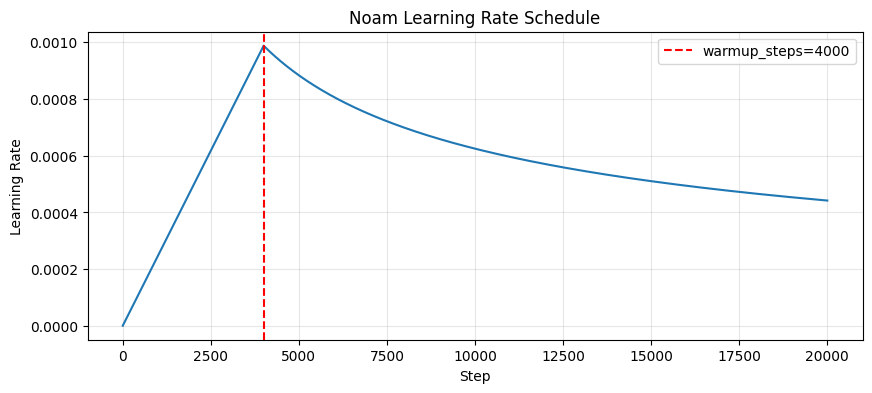

最大学習率: 0.000988 (step 4000)


In [18]:
# 学習率スケジューラの可視化
def visualize_lr_schedule():
    d_model = 256
    warmup_steps = 4000

    steps = range(1, 20001)
    lrs = []

    for step in steps:
        lr = (d_model ** -0.5) * min(step ** -0.5, step * warmup_steps ** -1.5)
        lrs.append(lr)

    plt.figure(figsize=(10, 4))
    plt.plot(steps, lrs)
    plt.axvline(x=warmup_steps, color='r', linestyle='--', label=f'warmup_steps={warmup_steps}')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Noam Learning Rate Schedule')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"最大学習率: {max(lrs):.6f} (step {lrs.index(max(lrs)) + 1})")

visualize_lr_schedule()

### Label Smoothing Loss

**Label Smoothing（ラベル平滑化）** は、過学習を防ぐための正則化テクニックの一つ

通常、分類タスクでは正解ラベルの確率を **1.0**、それ以外を **0.0** とする「one-hot ベクトル」をターゲットにする
- しかし、これはモデルに対して「絶対的な確信」を強いることになり、未知のデータに対する汎化性能が下がることがある

Label Smoothing では、正解ラベルの確率を少し下げ（例: 0.9）、残りの確率（例: 0.1）を語彙全体に均等に分配する

- **数式**:
  $$P(target) = 1.0 - \epsilon$$
  $$P(others) = \frac{\epsilon}{vocab\_size - 1}$$
  （$\epsilon$ は smoothing パラメータ）

- **実装のポイント**:
  - `smooth_label`: スムージング適用後のターゲット分布を作成します。
  - **パディング処理**: パディングトークン (`PAD_ID`) に対しては損失を計算しないよう、マスク処理を行う
  - **損失関数**: 分布間の距離を測るために、KLダイバージェンス (`F.log_softmax` とターゲット分布の積の総和) を用いる

### ビームサーチ (Beam Search) によるデコード

**貪欲法 (Greedy Decoding)** は、各ステップで最も確率の高い単語を1つだけ選ぶが、これは局所的には最適でも、文全体として最適な翻訳にならないことがある
**ビームサーチ** は、各ステップで上位 $k$ 個（ビーム幅 `beam_size`）の候補を保持しながら探索を進めるアルゴリズムであり、より自然で確度の高い翻訳文を見つけられる可能性が高くなる

- **処理の流れ**:
1. ソース文をエンコードして文脈ベクトルを得る（これは全候補で共通）
1. 最初の候補として `[BOS]` (スコア 0) を用意する
1. 各ステップで、保持している候補の続きとしてあり得る次単語の確率を計算し、累積スコア（対数尤度の和）を更新する
1. 全ての候補の中から、スコアが高い上位 `beam_size` 個だけを残し、他は切り捨てる
1. `[EOS]` (文末) が生成された候補は「完了」とみなし、探索から外して保存する
1. 指定の長さ `max_len` に達するか、全てのビームが完了したら終了する
1. 最終的に、スコア（長さによる正規化を行うことで、短すぎる文が選ばれるのを防ぐことが多い）が最も高い候補を結果として返す

In [19]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, vocab_size, padding_idx, smoothing=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, output, target):
        """
        Args:
            output: (batch * seq_len, vocab_size)
            target: (batch * seq_len)
        """
        output = output.view(-1, self.vocab_size)
        target = target.reshape(-1)

        # スムージングされたラベル分布を作成
        smooth_label = torch.full_like(output, self.smoothing / (self.vocab_size - 2))
        smooth_label.scatter_(1, target.unsqueeze(1), self.confidence)
        smooth_label[:, self.padding_idx] = 0

        # パディング位置をマスク
        mask = (target != self.padding_idx).unsqueeze(1)
        smooth_label = smooth_label * mask

        # KLダイバージェンス損失
        log_probs = F.log_softmax(output, dim=-1)
        loss = -torch.sum(smooth_label * log_probs) / mask.sum()

        return loss

## モデルの作成と訓練

実際に **Transformer モデルを構築し、PyTorch で学習を回す**部分を実装する


### ハイパーパラメータの設定

- `d_model`, `num_heads`, `num_layers`, `ffn_dim` など、Transformer の構造に関するパラメータ
- `batch_size`, `num_epochs`, `learning_rate`, `warmup_steps` など、学習に関するパラメータ
- 語彙サイズは学習済み SentencePiece モデルの `vocab_size()` を用いて決定

In [20]:
# ハイパーパラメータ
config = {
    'd_model': 256,
    'n_heads': 8,
    'n_encoder_layers': 4,
    'n_decoder_layers': 4,
    'd_ff': 1024,
    'dropout': 0.1,
    'max_seq_len': 128,
}

training_config = {
    'batch_size': 256,
    'n_epochs': 20,
    'warmup_steps': 4000,
    'label_smoothing': 0.1,
    'grad_clip': 1.0,
}

print("モデル設定:")
for key, value in config.items():
    print(f"  {key}: {value}")

print("\n訓練設定:")
for key, value in training_config.items():
    print(f"  {key}: {value}")

モデル設定:
  d_model: 256
  n_heads: 8
  n_encoder_layers: 4
  n_decoder_layers: 4
  d_ff: 1024
  dropout: 0.1
  max_seq_len: 128

訓練設定:
  batch_size: 256
  n_epochs: 20
  warmup_steps: 4000
  label_smoothing: 0.1
  grad_clip: 1.0


### モデルの生成

- 先ほど実装した Transformer クラスをインスタンス化し、GPU（CUDA）が利用可能であれば `to(device)` で移動
- 損失関数としてクロスエントロピーを用い、PAD トークンを損失計算から無視するように `ignore_index` を設定
- Optimizer として Adam、学習率更新に Noam スケジューラを組み合わせる

In [21]:
# モデルの作成
model = Transformer(
    src_vocab_size=sp_en.get_piece_size(),
    tgt_vocab_size=sp_ja.get_piece_size(),
    pad_idx=PAD_ID,
    **config
).to(device)

# パラメータ数
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f" パラメータ数: {total_params:,}")
print(f" 学習可能: {trainable_params:,}")

 パラメータ数: 13,525,824
 学習可能: 13,525,824


### 訓練ループ

`train_epoch` 関数では、
- 各バッチについて順伝播 → 損失計算 → 逆伝播 → 勾配クリッピング → パラメータ更新
- スケジューラによる学習率のステップ更新
- tqdm プログレスバーで各バッチの損失を逐次表示

エポックごとの訓練損失・検証損失をリストとして記録し、後で可視化する


### 損失カーブの可視化

`train_losses` と `dev_losses` をプロットし、
- 学習が進むにつれて損失が減少しているか
- 過学習（訓練損失だけ下がり、検証損失が上昇）が起きていないか  

を視覚的に確認します。

In [22]:
def train_epoch(model, dataloader, optimizer, scheduler, criterion, grad_clip):
    """1エポックの訓練"""
    model.train()
    total_loss = 0
    total_tokens = 0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        src = batch['src'].to(device)
        tgt = batch['tgt'].to(device)

        # Teacher Forcing
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()

        output = model(src, tgt_input)
        loss = criterion(output, tgt_output)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()
        scheduler.step()

        # トークン数でカウント（パディング除く）
        n_tokens = (tgt_output != PAD_ID).sum().item()
        total_loss += loss.item() * n_tokens
        total_tokens += n_tokens

    return total_loss / total_tokens


def evaluate(model, dataloader, criterion):
    """評価"""
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            loss = criterion(output, tgt_output)

            n_tokens = (tgt_output != PAD_ID).sum().item()
            total_loss += loss.item() * n_tokens
            total_tokens += n_tokens

    return total_loss / total_tokens

### DataLoader の構築

- `TranslationDataset` を訓練・検証用に分割し、それぞれ `DataLoader` でミニバッチ化
- シャッフルや `num_workers` などを指定することで、I/O 効率を改善

なお、Google ColabやJupyter Notebookでは、num_workers > 0の場合、ワーカープロセスの終了処理が正しく行われず、警告を発することがしばしばある

機能には影響しないため、無視してよいが、対策として、
- num_workers=0,  # ← これを追加または変更
- pin_memory=True if torch.cuda.is_available() else False, を追加して高速化

なお、次のようにして警告を無視することもできる
```
pythonimport warnings
warnings.filterwarnings('ignore')

# または特定のエラーのみ
import logging
logging.getLogger().setLevel(logging.ERROR)
```

In [23]:
# DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=training_config['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
)

dev_loader = DataLoader(
    dev_dataset,
    batch_size=training_config['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False,
    num_workers=0,
)

# オプティマイザと損失関数
optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
scheduler = NoamScheduler(optimizer, config['d_model'], training_config['warmup_steps'])
criterion = LabelSmoothingLoss(
    sp_ja.get_piece_size(),
    PAD_ID,
    training_config['label_smoothing']
)

print(f"バッチ数: 訓練={len(train_loader)}, 検証={len(dev_loader)}")

バッチ数: 訓練=196, 検証=2


訓練する

10分程度必要であるが、Transformerは学習が速い点に注目する

In [24]:
# 訓練ループ
print("=" * 60)
print("訓練開始")
print("=" * 60)

train_losses = []
dev_losses = []
best_dev_loss = float('inf')

for epoch in range(1, training_config['n_epochs'] + 1):
    train_loss = train_epoch(
        model, train_loader, optimizer, scheduler,
        criterion, training_config['grad_clip']
    )
    dev_loss = evaluate(model, dev_loader, criterion)

    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    # ベストモデルの保存
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        torch.save(model.state_dict(), 'best_model.pt')

    lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch:2d}/{training_config['n_epochs']} | "
          f"Train Loss: {train_loss:.4f} | Dev Loss: {dev_loss:.4f} | "
          f"LR: {lr:.6f}")

print("\n訓練完了")
print(f"   ベスト検証損失: {best_dev_loss:.4f}")

訓練開始


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  1/20 | Train Loss: 8.1204 | Dev Loss: 6.8626 | LR: 0.000048


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  2/20 | Train Loss: 5.6618 | Dev Loss: 4.6736 | LR: 0.000097


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  3/20 | Train Loss: 4.3127 | Dev Loss: 3.9519 | LR: 0.000145


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  4/20 | Train Loss: 3.8353 | Dev Loss: 3.6308 | LR: 0.000194


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  5/20 | Train Loss: 3.5533 | Dev Loss: 3.3753 | LR: 0.000242


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  6/20 | Train Loss: 3.3040 | Dev Loss: 3.1527 | LR: 0.000291


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  7/20 | Train Loss: 3.0722 | Dev Loss: 2.9616 | LR: 0.000339


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  8/20 | Train Loss: 2.8654 | Dev Loss: 2.7998 | LR: 0.000387


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch  9/20 | Train Loss: 2.6976 | Dev Loss: 2.6781 | LR: 0.000436


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 2.5633 | Dev Loss: 2.5975 | LR: 0.000484


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 2.4555 | Dev Loss: 2.5417 | LR: 0.000533


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 2.3670 | Dev Loss: 2.5087 | LR: 0.000581


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 2.2933 | Dev Loss: 2.4750 | LR: 0.000629


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 2.2329 | Dev Loss: 2.4659 | LR: 0.000678


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 2.1746 | Dev Loss: 2.4485 | LR: 0.000726


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 2.1257 | Dev Loss: 2.4313 | LR: 0.000775


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 2.0825 | Dev Loss: 2.4269 | LR: 0.000823


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 2.0421 | Dev Loss: 2.4389 | LR: 0.000872


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 2.0074 | Dev Loss: 2.4388 | LR: 0.000920


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 1.9748 | Dev Loss: 2.4310 | LR: 0.000968

訓練完了
   ベスト検証損失: 2.4269


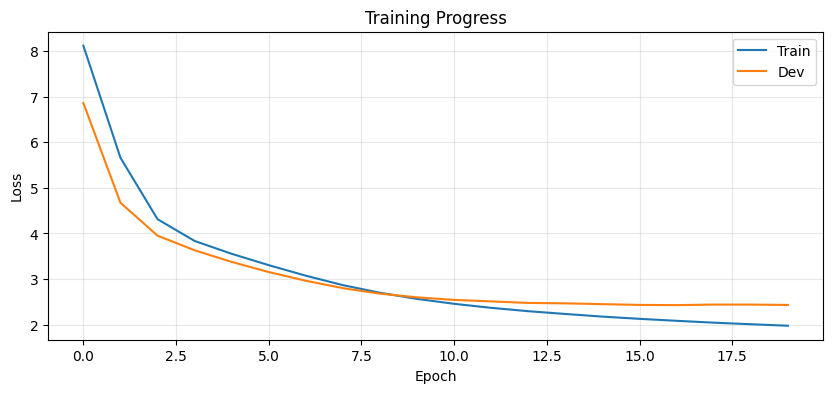

In [25]:
# 損失の推移をプロット
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train')
plt.plot(dev_losses, label='Dev')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 推論（翻訳）

学習が完了したら、次は **実際に文を入力して翻訳させる**


### 貪欲デコード (Greedy Decoding)
貪欲法 (Greedy Decoding) は、各ステップで最も確率の高い単語を1つだけ選びますが、これは局所的には最適でも、文全体として最適な翻訳にならないことがあります

- `greedy_decode(model, src_text, sp_src, sp_tgt, max_len=64)`  
  - 入力文 `src_text` をソース側トークナイザで ID 列に変換
  - エンコーダでコンテキスト表現を計算
  - デコーダでは、
    - `<bos>` から順に1トークンずつ生成し、毎ステップ最尤トークンを選択（貪欲法）
  - `<eos>` が出現、または `max_len` に達した段階で生成を停止




In [26]:
def greedy_decode(model, src_text, sp_src, sp_tgt, max_len=64):
    """
    Greedy Decoding
    """
    model.eval()

    # ソースのエンコード
    src_ids = [BOS_ID] + sp_src.encode_as_ids(src_text) + [EOS_ID]
    src_tensor = torch.tensor(src_ids).unsqueeze(0).to(device)
    src_mask = (src_tensor != PAD_ID).unsqueeze(1).unsqueeze(2)

    with torch.no_grad():
        encoder_output = model.encode(src_tensor, src_mask)

    # デコード
    tgt_ids = [BOS_ID]

    for _ in range(max_len):
        tgt_tensor = torch.tensor(tgt_ids).unsqueeze(0).to(device)
        tgt_len = tgt_tensor.size(1)
        tgt_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=device)).bool()
        tgt_mask = tgt_mask.unsqueeze(0).unsqueeze(0)

        with torch.no_grad():
            decoder_output = model.decode(tgt_tensor, encoder_output, src_mask, tgt_mask)
            output = model.output_layer(decoder_output)

        next_token = output[0, -1, :].argmax().item()
        tgt_ids.append(next_token)

        if next_token == EOS_ID:
            break

    # デコード（特殊トークンを除去）
    result_ids = [id for id in tgt_ids if id not in [PAD_ID, BOS_ID, EOS_ID]]
    return sp_tgt.decode_ids(result_ids)

### ビームサーチ (Beam Search) によるデコード

**ビームサーチ** は、各ステップで上位 $k$ 個（ビーム幅 `beam_size`）の候補を保持しながら探索を進めるアルゴリズムです。これにより、より自然で確度の高い翻訳文を見つけられる可能性が高まります。

**処理の流れ**

1. ソース文をエンコードして文脈ベクトルを得ます（これは全候補で共通）。
1. 最初の候補として `[BOS]` (スコア 0) を用意します。
1. 各ステップで、保持している候補の続きとしてあり得る次単語の確率を計算し、累積スコア（対数尤度の和）を更新します。
1. 全ての候補の中から、スコアが高い上位 `beam_size` 個だけを残し、他は切り捨てます。
1. `[EOS]` (文末) が生成された候補は「完了」とみなし、探索から外して保存します。
1. 指定の長さ `max_len` に達するか、全てのビームが完了したら終了します。
1. 最終的に、スコア（長さによる正規化を行うことで、短すぎる文が選ばれるのを防ぐことが多い）が最も高い候補を結果として返します。

In [27]:
def beam_search_decode(model, src_text, sp_src, sp_tgt, beam_size=5, max_len=64):
    """
    Beam Search Decoding

    複数の候補を同時に探索して、より良い翻訳を見つけます。
    """
    model.eval()

    # ソースのエンコード
    src_ids = [BOS_ID] + sp_src.encode_as_ids(src_text) + [EOS_ID]
    src_tensor = torch.tensor(src_ids).unsqueeze(0).to(device)
    src_mask = (src_tensor != PAD_ID).unsqueeze(1).unsqueeze(2)

    with torch.no_grad():
        encoder_output = model.encode(src_tensor, src_mask)

    # ビームの初期化
    # 各ビーム: (累積対数確率, トークン列)
    beams = [(0.0, [BOS_ID])]
    completed = []

    for _ in range(max_len):
        all_candidates = []

        for score, seq in beams:
            if seq[-1] == EOS_ID:
                completed.append((score, seq))
                continue

            tgt_tensor = torch.tensor(seq).unsqueeze(0).to(device)
            tgt_len = tgt_tensor.size(1)
            tgt_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=device)).bool()
            tgt_mask = tgt_mask.unsqueeze(0).unsqueeze(0)

            with torch.no_grad():
                decoder_output = model.decode(tgt_tensor, encoder_output, src_mask, tgt_mask)
                output = model.output_layer(decoder_output)
                log_probs = F.log_softmax(output[0, -1, :], dim=-1)

            # 上位k個のトークンを取得
            topk_log_probs, topk_ids = log_probs.topk(beam_size)

            for log_prob, token_id in zip(topk_log_probs.tolist(), topk_ids.tolist()):
                new_seq = seq + [token_id]
                new_score = score + log_prob
                all_candidates.append((new_score, new_seq))

        if not all_candidates:
            break

        # 上位beam_size個を保持
        all_candidates.sort(key=lambda x: x[0], reverse=True)
        beams = all_candidates[:beam_size]

    # 完了したビームと未完了のビームを合わせて最良を選択
    all_results = completed + beams
    if not all_results:
        return ""

    # 長さで正規化したスコアで選択
    best_seq = max(all_results, key=lambda x: x[0] / len(x[1]))[1]

    result_ids = [id for id in best_seq if id not in [PAD_ID, BOS_ID, EOS_ID]]
    return sp_tgt.decode_ids(result_ids)

### ベストモデルのロードとテスト

- 訓練中に保存しておいた **検証損失が最良のモデルパラメータ**をロード
- いくつかの例文に対して翻訳を実行し、
  - ソース文
  - モデル出力（ターゲット文）  
  を並べて表示することで、翻訳の質を目視で評価する

In [28]:
# ベストモデルをロード
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

print("ベストモデルをロードしました")

ベストモデルをロードしました


In [29]:
# 翻訳テスト
def test_translation(n_samples=10):
    print("=" * 60)
    print("翻訳テスト（テストセットから）")
    print("=" * 60)

    # ランダムにサンプルを選択
    indices = np.random.choice(len(test_pairs), n_samples, replace=False)

    for idx in indices:
        src_text, ref_text = test_pairs[idx]

        # Greedy
        greedy_output = greedy_decode(model, src_text, sp_en, sp_ja)

        # Beam Search
        beam_output = beam_search_decode(model, src_text, sp_en, sp_ja, beam_size=5)

        print(f"\nSource (EN): {src_text}")
        print(f"   Reference:   {ref_text}")
        print(f"   Greedy:      {greedy_output}")
        print(f"   Beam(5):     {beam_output}")

test_translation(10)

翻訳テスト（テストセットから）

Source (EN): can other people catch it ?
   Reference:   感染 症 の 病気 で す か 。
   Greedy:      それ を 木 に でき ま す か 。
   Beam(5):     それ に つ い て もらえ ま す か 。

Source (EN): it was around eight last night when the meeting broke up .
   Reference:   会 が 散会 し た の は 昨夜 ８ 時 ごろ だっ た 。
   Greedy:      会議 が 起き た 時 は 8 時 の 時 で す 。
   Beam(5):     会議 が 終わ っ た とき は 8 時 で あ っ た 。

Source (EN): i don 't like shellfish .
   Reference:   貝 は 好き で は な い 。
   Greedy:      私 は あまり に も 足 が 好き で は な い 。
   Beam(5):     私 は 足 が 好き で は な い 。

Source (EN): he asked me which way to go .
   Reference:   彼 は 私 に どっち へ 行 け ば い い の か 尋ね た 。
   Greedy:      彼 は どちら へ 行 く 道 を 私 に 頼 ん だ 。
   Beam(5):     彼 は どちら へ 行 く 道 を 私 に 頼 ん だ 。

Source (EN): you should not break your promise .
   Reference:   約束 を 破 っ て は な ら な い 。
   Greedy:      約束 を 破 る べ き で は な い 。
   Beam(5):     約束 を 破 る べ き で は な い 。

Source (EN): the car accident took place just in front of me .
   Reference:   ちょうど 私 の 目 の 前 で 自動 車 事故 が 起こ っ 

## 9. BLEUスコアによる評価

翻訳モデルの性能を客観的に比較するためには、**定量的な評価指標**が必要である
- ここでは、機械翻訳で広く用いられる **BLEU スコア**を利用して評価する

### BLEU スコアとは

- 生成文と参照文（正解文）との **n-gram レベルの一致度**を測る指標
- 単に一致する単語数を数えるのではなく、
  - 1-gram, 2-gram, 3-gram, 4-gram … といった n-gram を考慮
  - 文長のペナルティ（brevity penalty）も導入

### このセクションの関数

- `calculate_bleu(model, test_pairs, sp_src, sp_tgt, use_beam=False, beam_size=5)`  
  - テスト用の対訳ペア `test_pairs` に対して、モデルの出力と参照文を比較
  - 必要に応じて **ビームサーチ (Beam Search)** によるデコードもサポート（`use_beam=True` の場合）
  - 全テスト文の BLEU スコアを平均し、モデルの性能として報告

これにより、
- モデルの改善前後
- ハイパーパラメータの設定違い
- ビームサーチの有無

などを、**数値的に比較** できるようになる

In [30]:
def calculate_bleu(model, test_pairs, sp_src, sp_tgt, use_beam=False, beam_size=5):
    """
    テストセット全体のBLEUスコアを計算
    """
    hypotheses = []
    references = []

    print("翻訳中...")
    for src_text, ref_text in tqdm(test_pairs):
        if use_beam:
            hyp = beam_search_decode(model, src_text, sp_src, sp_tgt, beam_size)
        else:
            hyp = greedy_decode(model, src_text, sp_src, sp_tgt)

        hypotheses.append(hyp)
        references.append(ref_text)

    # sacrebleuでBLEUスコアを計算
    bleu = sacrebleu.corpus_bleu(hypotheses, [references])

    return bleu, hypotheses, references

# Greedy DecodeでのBLEU
print("\nGreedy Decoding での評価:")
bleu_greedy, hyps_greedy, refs = calculate_bleu(model, test_pairs, sp_en, sp_ja, use_beam=False)
print(f"   BLEU Score: {bleu_greedy.score:.2f}")

# Beam SearchでのBLEU（時間がかかるので一部のみ）
print("\nBeam Search (beam=5) での評価 (最初の500文):")
bleu_beam, hyps_beam, _ = calculate_bleu(model, test_pairs[:500], sp_en, sp_ja, use_beam=True, beam_size=5)
print(f"   BLEU Score: {bleu_beam.score:.2f}")


Greedy Decoding での評価:
翻訳中...


  0%|          | 0/500 [00:00<?, ?it/s]

   BLEU Score: 34.86

Beam Search (beam=5) での評価 (最初の500文):
翻訳中...


  0%|          | 0/500 [00:00<?, ?it/s]

   BLEU Score: 36.28


## 自由な文の翻訳

ユーザが任意に入力した文に対して、モデルに翻訳させるインターフェースを用意する

### `translate(text, use_beam=True, beam_size=5)` 関数

- 引数 `text` に与えられたソース文を、
  - トークナイズ → テンソル化 → モデルに入力 → ID 列から文字列へ復元  
    という一連の処理をラップした関数
- `use_beam=True` とすることで、ビームサーチによる推論も可能です。
  - ビーム幅 `beam_size` を大きくすると、より広い候補を探索できる一方で、計算量は増加

### インタラクティブな利用

- ノートブック上のセルを実行すると、`input()` を使って対話的に文を入力し、その場で翻訳結果を確認できるようなコード例も含まれている

In [31]:
def translate(text, use_beam=True, beam_size=5):
    """
    任意の英文を日本語に翻訳
    """
    # 小文字化（訓練データに合わせる）
    text = text.lower()

    if use_beam:
        result = beam_search_decode(model, text, sp_en, sp_ja, beam_size)
    else:
        result = greedy_decode(model, text, sp_en, sp_ja)

    return result

# 翻訳テスト
test_sentences = [
    "I love you.",
    "Thank you very much.",
    "What time is it now?",
    "I want to go to Japan.",
    "She is a beautiful woman.",
    "He can speak Japanese.",
    "I am learning English.",
    "This is a good book.",
]

print("=" * 60)
print("自由翻訳テスト")
print("=" * 60)

for sentence in test_sentences:
    translation = translate(sentence)
    print(f"\n  EN: {sentence}")
    print(f"  JA: {translation}")

自由翻訳テスト

  EN: I love you.
  JA: あなた を 愛 し て い ま す 。

  EN: Thank you very much.
  JA: ありがとう ござ い ま す 。

  EN: What time is it now?
  JA: 今 に は 何 時 で す 。

  EN: I want to go to Japan.
  JA: 私 は 日本 に 行 き た い 。

  EN: She is a beautiful woman.
  JA: 彼女 は 美人 だ 。

  EN: He can speak Japanese.
  JA: 彼 は 日本 語 が 話せ る 。

  EN: I am learning English.
  JA: 私 は 英語 を 勉強 し て い ま す 。

  EN: This is a good book.
  JA: これ は よ い 本 で す 。


In [32]:
# インタラクティブな翻訳（お試し用）
def interactive_translate():
    print("\n" + "=" * 60)
    print("🎮 インタラクティブ翻訳モード")
    print("   英語を入力すると日本語に翻訳します")
    print("   'quit' で終了")
    print("=" * 60)

    while True:
        text = input("\nEN > ")
        if text.lower() == 'quit':
            print("終了します。")
            break

        translation = translate(text)
        print(f"JA > {translation}")

# Colabでは以下を実行
# interactive_translate()

## 11. Attention の可視化

Transformer の大きな特徴は、**Attention 機構**によって「どの単語がどの単語に注目しているか」を明示的に扱える点である

### `visualize_attention(src_text, model, sp_src, sp_tgt)`

- 指定した入力文 `src_text` に対して、
  - エンコーダ出力とデコーダの Attention 重みを取得
  - 1つまたは複数のヘッドについて、
    - x 軸: ソース文のトークン
    - y 軸: デコーダ側（生成文）のトークン  
    のヒートマップとして表示する

- 図から以下が読み取れる
  - 各ターゲットトークンが、ソース文中のどの位置（単語・サブワード）に強く反応しているか
  - 文法上の対応（主語・目的語など）が自然に学習されているか
  - 翻訳の誤りが、どの Attention パターンに起因していそうか
  
  など


In [33]:
# 日本語化ライブラリの導入
!pip install japanize-matplotlib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 42.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


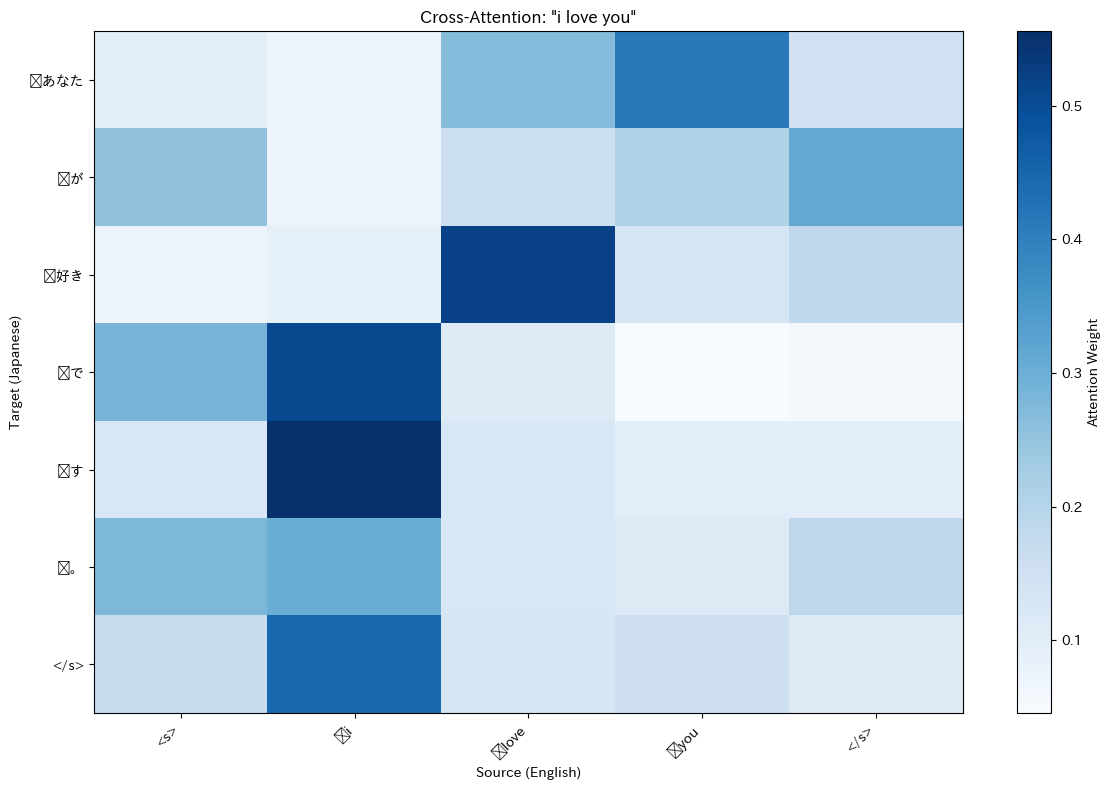


翻訳結果: あなた が 好き で す 。


In [34]:
import japanize_matplotlib
def visualize_attention(src_text, model, sp_src, sp_tgt):
    """
    Cross-Attention の可視化
    """
    model.eval()

    # ソースのエンコード
    src_ids = [BOS_ID] + sp_src.encode_as_ids(src_text) + [EOS_ID]
    src_tensor = torch.tensor(src_ids).unsqueeze(0).to(device)
    src_mask = (src_tensor != PAD_ID).unsqueeze(1).unsqueeze(2)

    with torch.no_grad():
        encoder_output = model.encode(src_tensor, src_mask)

    # デコード（Attention重みを保存）
    tgt_ids = [BOS_ID]
    attention_weights_list = []

    for _ in range(50):
        tgt_tensor = torch.tensor(tgt_ids).unsqueeze(0).to(device)
        tgt_len = tgt_tensor.size(1)
        tgt_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=device)).bool()
        tgt_mask = tgt_mask.unsqueeze(0).unsqueeze(0)

        with torch.no_grad():
            decoder_output = model.decode(tgt_tensor, encoder_output, src_mask, tgt_mask)
            output = model.output_layer(decoder_output)

        # Cross-Attention重み（最後のDecoder層）
        cross_attn = model.decoder_layers[-1].cross_attn.attention_weights
        attention_weights_list.append(cross_attn[0, :, -1, :].cpu())

        next_token = output[0, -1, :].argmax().item()
        tgt_ids.append(next_token)

        if next_token == EOS_ID:
            break

    # Attention重みを結合（ヘッドの平均）
    attention_weights = torch.stack(attention_weights_list, dim=0)  # (tgt_len, n_heads, src_len)
    attention_weights = attention_weights.mean(dim=1).numpy()  # (tgt_len, src_len)

    # ラベル
    src_tokens = ['<s>'] + sp_src.encode_as_pieces(src_text) + ['</s>']
    tgt_tokens = [sp_tgt.id_to_piece(id) for id in tgt_ids[1:]]  # BOSを除く

    # プロット
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(attention_weights, cmap='Blues', aspect='auto')

    ax.set_xticks(range(len(src_tokens)))
    ax.set_xticklabels(src_tokens, rotation=45, ha='right')
    ax.set_yticks(range(len(tgt_tokens)))
    ax.set_yticklabels(tgt_tokens)

    ax.set_xlabel('Source (English)')
    ax.set_ylabel('Target (Japanese)')
    ax.set_title(f'Cross-Attention: "{src_text}"')

    plt.colorbar(im, label='Attention Weight')
    plt.tight_layout()
    plt.show()

    # 翻訳結果
    result_ids = [id for id in tgt_ids if id not in [PAD_ID, BOS_ID, EOS_ID]]
    print(f"\n翻訳結果: {sp_tgt.decode_ids(result_ids)}")

# 可視化
visualize_attention("i love you", model, sp_en, sp_ja)

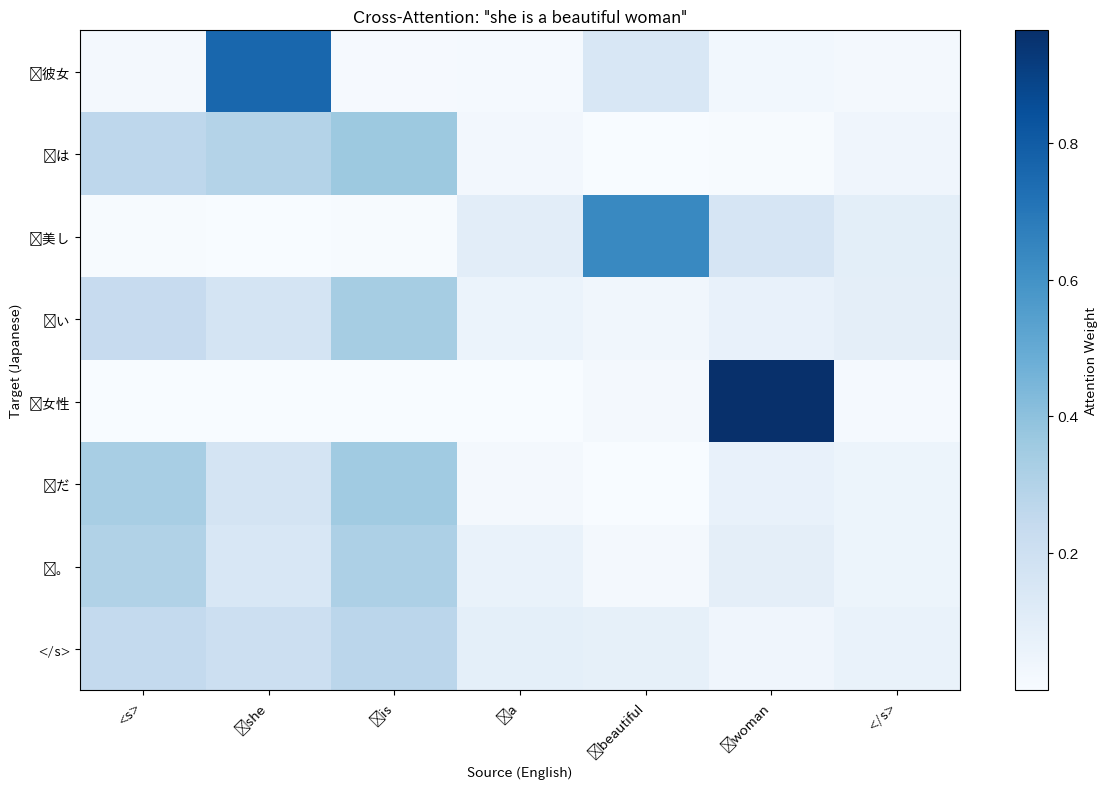


翻訳結果: 彼女 は 美し い 女性 だ 。


In [35]:
visualize_attention("she is a beautiful woman", model, sp_en, sp_ja)

# 課題1

## モデル規模の変更

層数・ヘッド数・埋め込み次元などを変えて、性能と計算コストのトレードオフを検証しなさい


## データセットの拡張
より大規模なコーパスで再学習し、BLEU スコアの向上を図りなさい

## 正則化・正則化テクニックの導入
Label Smoothing, Dropout, 重み減衰などによる汎化性能の改善手法を取り入れて評価しなさい

## ビームサーチや長さ正則化の工夫
翻訳の自然さ向上し、過度な短文／長文生成の抑制しなさい

## 他言語への応用

多言語翻訳モデルへ拡張しなさい

# 事前学習＋ファインチューニング

ここまでは、日英翻訳タスクのデータのみを用いて **ゼロからモデルを訓練する（from scratch）** 方法を見てきた

しかし、現代の自然言語処理では **事前学習（Pre-training）** と **ファインチューニング（Fine-tuning）** の2段階アプローチが主流となっている


## From scratch と Pre-training+Fine-tuning

### from scratch
- from scratchはタスク専用でゼロから学習すること
- 使うデータ：ターゲットタスクのみ（例：日英翻訳コーパス）
- 学習の目的：最初から最適な翻訳モデルを構築

欠点: 多くのデータが必要で、例えばWorkshop on Machine Translation(WMT)レベルの数千万
- 言語の一般知識は含まれず、狭い能力しか身に付かない

この、タスク専用データが膨大に必要という点が問題
- べき乗測から外れるため、高性能化が難しい

### 事前学習(Pre-training)+ファインチューニング(Fine-tuning)

- 巨大テキストで言語知識を獲得（Web・書籍・Wikipedia など）
- ファインチューニングで懸案タスク（日英翻訳など）へ適応
- データ効率が圧倒的に良い
- Pretrain では既に言語知識を獲得しているため少量データでも高性能

代表的研究

ELMo (Peters et al., 2018, NAACL)
→ Pretrain による contextual embedding の有効性を証明

BERT (Devlin et al., 2018, NAACL)
→ マスク言語モデルと次文予測で一般言語理解

GPT (Radford et al., 2018–)
→ 大規模事前学習のみで多様な能力獲得




## 事前学習+ファインチューニングによるメリット

- 少量データでも優れたモデルを作成できる
  - BERT（事前学習+微調整）はタスク毎の訓練データが数千で十分（論文公開時比で従来法を大幅に上回る）
- 多用途（transfer）の一般知識を獲得
  - 事前学習中に以下が獲得されると論文で示されている：
    - 語彙・文法・構文
    - 文脈理解（semantic role, co-reference）
    - 世界知識の断片（Talmor et al., 2020）
  - 翻訳／QA／要約／分類など多くのタスクに流用可能
- 計算資源と実用性の観点
  - 大企業・研究機関が巨大モデルを pretrain して公開
    - BERT / RoBERTa / GPT-系 / T5 / mBERT / XLM-R
  - 研究者・企業はそれを微調整するだけで使える
    - モデルの民主化が起きた
- 性能向上が図れる(ほぼすべてのベンチマークで実証)
  - BERT: GLUE, SQuAD で当時の SOTA 達成
  - GPT-3: few-shot で多様なタスクを達成
- 低データ領域に強い
  - 医療／法務／方言コーパスのようにデータが希少でも成功例多数（BioBERT, ClinicalBERT, LegalBERT など）
- 多言語対応
  - mBERT, XLM-R は 単一モデルで100+言語に対応（Conneau et al., 2019）

では欠点は？
- 巨大な事前学習が必要
  - 訓練計算資源は極めて大きい（GPT-3 訓練：数千 GPU・数週間：Brown et al., 2020）
  - Web データ由来で差別・社会的バイアスを含む可能性があることから、バイアス・安全性の問題がある
  - 微調整が強すぎると汎化性能が落ちるため、タスク過学習の危険がある
    - 例としてCatastrophic forgetting
    - 対策としてLoRA, Prefix-tuning, adapters
- 推論コストが高いこともある
  - 大モデルでは推論時間・メモリ消費が増大
    - 対策として、量子化（INT8/INT4）や蒸留(DistilBERT)

事前学習が有効な理由をまとめる

1. **言語の一般的な知識の獲得**
   - 大量のテキストデータから、文法、語彙、意味的な関係性など、言語の基礎的なパターンを学習できる
   - これにより、下流タスク（翻訳など）で必要な基礎能力をあらかじめ身につけておける

1. **データ効率の向上**
   - 対訳データ（ペアになったデータ）は収集コストが高いが、単言語データ（モノリンガルデータ）は大量に入手可能
   - 事前学習で単言語データを活用し、少量の対訳データで効率的にファインチューニングできる

1. **汎化性能の向上**
   - 多様なテキストで学習することで、特定のドメインに過度に依存しない頑健な表現を獲得できる

## 事前学習の代表的な手法

| 手法 | 説明 | 代表モデル |
|------|------|----------|
| **MLM (Masked Language Modeling)** | 入力の一部をマスクし、それを予測する | BERT, RoBERTa |
| **CLM (Causal Language Modeling)** | 次の単語を予測する自己回帰型 | GPT, GPT-2 |
| **DAE (Denoising Auto-Encoding)** | ノイズを加えた文から元の文を復元する | BART, T5 |
| **TLM (Translation Language Modeling)** | 対訳ペアを連結してMLMを行う | XLM |

ここでは、**Masked Language Modeling (MLM)** による事前学習と、それに続くファインチューニングを実装する

## Masked Language Modeling (MLM) の実装

MLM は BERT で導入された事前学習タスクで、以下の手順で学習を行う：

1. 入力系列のトークンのうち、一定割合（通常 15%）をランダムに選択
2. 選択されたトークンに対して：
   - 80% の確率で `[MASK]` トークンに置き換える
   - 10% の確率でランダムな別のトークンに置き換える
   - 10% の確率でそのまま（変更なし）
3. モデルは元のトークンを予測するように学習する

```
入力: "私 は テニス 部員 です"
       ↓ 15% をマスク
マスク後: "私 は [MASK] 部員 です"
       ↓ モデルが予測
予測: "テニス" (正解と比較して損失を計算)
```

この学習により、モデルは文脈から単語を推測する能力を獲得し、それが翻訳などの下流タスクに転移する

In [36]:
# ========================================
# MLM (Masked Language Modeling) の実装
# ========================================

class MLMDataset(Dataset):
    """
    Masked Language Modeling 用データセット

    入力テキストの一部をマスクし、元のトークンを予測するタスクのためのデータを生成する
    """

    def __init__(self, texts, sp_model, max_len=64, mask_prob=0.15):
        """
        Args:
            texts: テキストのリスト（単言語データ）
            sp_model: SentencePiece モデル
            max_len: 最大系列長
            mask_prob: マスクする確率
        """
        self.texts = texts
        self.sp = sp_model
        self.max_len = max_len
        self.mask_prob = mask_prob

        # 特殊トークンのID
        self.pad_id = sp_model.pad_id()
        self.bos_id = sp_model.bos_id()
        self.eos_id = sp_model.eos_id()
        self.unk_id = sp_model.unk_id()
        self.vocab_size = sp_model.get_piece_size()

        # [MASK] トークンのID（語彙に存在しない場合はUNKを使用）
        self.mask_id = self.unk_id

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # トークナイズ
        tokens = self.sp.encode(text, out_type=int)

        # BOS/EOS を追加して最大長に切り詰め
        tokens = [self.bos_id] + tokens[:self.max_len - 2] + [self.eos_id]

        # マスク処理
        input_ids, labels = self._apply_mask(tokens)

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long),
        }

    def _apply_mask(self, tokens):
        """
        トークン列にマスクを適用

        Returns:
            input_ids: マスク適用後の入力ID列
            labels: 元のトークンID（マスクされなかった位置は -100 で損失計算から除外）
        """
        input_ids = tokens.copy()
        labels = [-100] * len(tokens)  # -100 は損失計算から除外される

        for i in range(1, len(tokens) - 1):  # BOS/EOS はマスクしない
            if np.random.random() < self.mask_prob:
                labels[i] = tokens[i]  # 元のトークンを保存

                rand = np.random.random()
                if rand < 0.8:
                    # 80%: [MASK] に置き換え
                    input_ids[i] = self.mask_id
                elif rand < 0.9:
                    # 10%: ランダムなトークンに置き換え
                    input_ids[i] = np.random.randint(4, self.vocab_size)
                # 10%: そのまま（何もしない）

        return input_ids, labels


def collate_fn_mlm(batch):
    """
    MLM用のバッチ作成関数
    """
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['labels'] for item in batch]

    # パディング
    input_ids = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        'input_ids': input_ids,
        'labels': labels,
    }

print("MLMDataset クラスを定義")

MLMDataset クラスを定義


## 事前学習用エンコーダモデル

MLM による事前学習では、**Encoder** 部分のみを使用する

- 双方向の文脈を利用してマスクされたトークンを予測するため、Encoder の Self-Attention が適している
- 学習後、この Encoder の重みを翻訳モデルの Encoder 部分に転移する

以下では、事前学習用の `PretrainEncoder` クラスを定義する

In [37]:
class PretrainEncoder(nn.Module):
    """
    事前学習用のエンコーダモデル

    MLMタスク用にエンコーダ＋予測ヘッドで構成される
    学習後、エンコーダ部分の重みを翻訳モデルに転移できる
    """

    def __init__(self, vocab_size, d_model=256, n_heads=8, n_layers=4,
                 ffn_dim=1024, dropout=0.1, max_len=512):
        super().__init__()

        self.d_model = d_model

        # 埋め込み層
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)
        self.scale = math.sqrt(d_model)

        # エンコーダ層のスタック
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, ffn_dim, dropout)
            for _ in range(n_layers)
        ])

        self.norm = nn.LayerNorm(d_model)

        # MLM予測ヘッド
        self.mlm_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, vocab_size)
        )

    def forward(self, input_ids, mask=None):
        """
        Args:
            input_ids: (batch_size, seq_len) 入力トークンID
            mask: (batch_size, seq_len) パディングマスク

        Returns:
            logits: (batch_size, seq_len, vocab_size) 各位置の予測ロジット
        """
        # パディングマスクの作成
        if mask is None:
            # PAD(0)でない場所をTrueにし、次元を拡張して (batch, 1, 1, seq_len) にする
            mask = (input_ids != 0).unsqueeze(1).unsqueeze(2)

        # 埋め込み + 位置エンコーディング
        x = self.embedding(input_ids) * self.scale
        x = self.pos_encoding(x)

        # エンコーダ層を通過
        for layer in self.encoder_layers:
            x = layer(x, mask)

        x = self.norm(x)

        # MLM予測
        logits = self.mlm_head(x)

        return logits

    def get_encoder_state_dict(self):
        """
        エンコーダ部分の重みのみを取得（転移学習用）
        """
        encoder_state = {}
        for name, param in self.state_dict().items():
            if not name.startswith('mlm_head'):
                encoder_state[name] = param
        return encoder_state

print("PretrainEncoder クラスを定義")

PretrainEncoder クラスを定義


## 事前学習の実行

ここでは、日本語と英語の単言語データを用いて MLM による事前学習を行う

- 訓練データから英語文と日本語文を別々に取り出し、それぞれで MLM を行う
- 実際の大規模事前学習では、Wikipedia やニュース記事など膨大なテキストを使用するが、ここではデモとして対訳コーパスの文を流用する
- 計算時間の都合上、エポック数を抑えて実行する

In [38]:
def pretrain_encoder(model, dataloader, optimizer, scheduler, num_epochs=3, device='cuda'):
    """
    MLMによる事前学習を実行

    Args:
        model: PretrainEncoder モデル
        dataloader: MLMDataset の DataLoader
        optimizer: オプティマイザ
        scheduler: 学習率スケジューラ
        num_epochs: エポック数
        device: デバイス

    Returns:
        losses: 各ステップの損失リスト
    """
    model.train()
    losses = []
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  # -100 は無視

    for epoch in range(num_epochs):
        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f'Pretrain Epoch {epoch+1}/{num_epochs}')

        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            # 順伝播
            logits = model(input_ids)

            # 損失計算（形状を調整）
            loss = criterion(
                logits.view(-1, logits.size(-1)),
                labels.view(-1)
            )

            # 逆伝播
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()
            losses.append(loss.item())
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch {epoch+1} - Average Loss: {avg_loss:.4f}')

    return losses


print("pretrain_encoder 関数を定義")

pretrain_encoder 関数を定義


In [39]:
# ========================================
# 事前学習の実行
# ========================================

print("=" * 60)
print("事前学習の準備")
print("=" * 60)

# 単言語データの準備（対訳データから片言語を抽出）
en_texts = [pair[0] for pair in train_pairs]
ja_texts = [pair[1] for pair in train_pairs]

print(f"英語テキスト数: {len(en_texts):,}")
print(f"日本語テキスト数: {len(ja_texts):,}")

# 英語用の事前学習モデルを作成
pretrain_model_en = PretrainEncoder(
    vocab_size=sp_en.get_piece_size(),
    d_model=config['d_model'],
    n_heads=config['n_heads'],
    n_layers=config['n_encoder_layers'],
    ffn_dim=config['d_ff'],  # 修正: 'ffn_dim' -> 'd_ff'
    dropout=config['dropout']
).to(device)

# 日本語用の事前学習モデルを作成
pretrain_model_ja = PretrainEncoder(
    vocab_size=sp_ja.get_piece_size(),
    d_model=config['d_model'],
    n_heads=config['n_heads'],
    n_layers=config['n_decoder_layers'],
    ffn_dim=config['d_ff'],  # 修正: 'ffn_dim' -> 'd_ff'
    dropout=config['dropout']
).to(device)

print(f"\n英語事前学習モデルのパラメータ数: {sum(p.numel() for p in pretrain_model_en.parameters()):,}")
print(f"日本語事前学習モデルのパラメータ数: {sum(p.numel() for p in pretrain_model_ja.parameters()):,}")

事前学習の準備
英語テキスト数: 50,000
日本語テキスト数: 50,000

英語事前学習モデルのパラメータ数: 7,329,856
日本語事前学習モデルのパラメータ数: 7,329,856


In [40]:
# ========================================
# 英語エンコーダの事前学習
# ========================================

print("\n" + "=" * 60)
print("英語エンコーダの事前学習")
print("=" * 60)

# 【修正反映のためモデルを再作成】
# クラス定義の変更を確実に反映させるため、ここでモデルを再初期化します
pretrain_model_en = PretrainEncoder(
    vocab_size=sp_en.get_piece_size(),
    d_model=config['d_model'],
    n_heads=config['n_heads'],
    n_layers=config['n_encoder_layers'],
    ffn_dim=config['d_ff'],
    dropout=config['dropout']
).to(device)

# データセットとDataLoaderの作成
mlm_dataset_en = MLMDataset(en_texts, sp_en, max_len=config['max_seq_len'])
mlm_loader_en = DataLoader(
    mlm_dataset_en,
    batch_size=training_config['batch_size'],
    shuffle=True,
    collate_fn=collate_fn_mlm
)

# オプティマイザとスケジューラ
pretrain_optimizer_en = optim.AdamW(
    pretrain_model_en.parameters(),
    lr=1e-4,
    betas=(0.9, 0.98)
)
pretrain_scheduler_en = NoamScheduler(
    pretrain_optimizer_en,
    d_model=config['d_model'],
    warmup_steps=500
)

# 事前学習の実行（デモのため2エポック）
pretrain_losses_en = pretrain_encoder(
    pretrain_model_en,
    mlm_loader_en,
    pretrain_optimizer_en,
    pretrain_scheduler_en,
    num_epochs=2,
    device=device
)

# 事前学習済み重みを保存
torch.save(pretrain_model_en.get_encoder_state_dict(), 'pretrain_encoder_en.pt')
print("\n英語エンコーダの事前学習完了")


英語エンコーダの事前学習


Pretrain Epoch 1/2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 6.2465


Pretrain Epoch 2/2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 5.1351

英語エンコーダの事前学習完了


In [41]:
# ========================================
# 日本語エンコーダの事前学習（デコーダ初期化用）
# ========================================

print("\n" + "=" * 60)
print("日本語エンコーダの事前学習")
print("=" * 60)

# 【修正反映のためモデルを再作成】
# 日本語モデルは翻訳モデルのDecoder初期化に使われるため、層数は n_decoder_layers を指定します
pretrain_model_ja = PretrainEncoder(
    vocab_size=sp_ja.get_piece_size(),
    d_model=config['d_model'],
    n_heads=config['n_heads'],
    n_layers=config['n_decoder_layers'],
    ffn_dim=config['d_ff'],
    dropout=config['dropout']
).to(device)

# データセットとDataLoaderの作成
mlm_dataset_ja = MLMDataset(ja_texts, sp_ja, max_len=config['max_seq_len'])
mlm_loader_ja = DataLoader(
    mlm_dataset_ja,
    batch_size=training_config['batch_size'],
    shuffle=True,
    collate_fn=collate_fn_mlm
)

# オプティマイザとスケジューラ
pretrain_optimizer_ja = optim.AdamW(
    pretrain_model_ja.parameters(),
    lr=1e-4,
    betas=(0.9, 0.98)
)
pretrain_scheduler_ja = NoamScheduler(
    pretrain_optimizer_ja,
    d_model=config['d_model'],
    warmup_steps=500
)

# 事前学習の実行（デモのため2エポック）
pretrain_losses_ja = pretrain_encoder(
    pretrain_model_ja,
    mlm_loader_ja,
    pretrain_optimizer_ja,
    pretrain_scheduler_ja,
    num_epochs=2,
    device=device
)

# 事前学習済み重みを保存
torch.save(pretrain_model_ja.get_encoder_state_dict(), 'pretrain_encoder_ja.pt')
print("\n日本語エンコーダの事前学習完了")


日本語エンコーダの事前学習


Pretrain Epoch 1/2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 5.8474


Pretrain Epoch 2/2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 4.6300

日本語エンコーダの事前学習完了


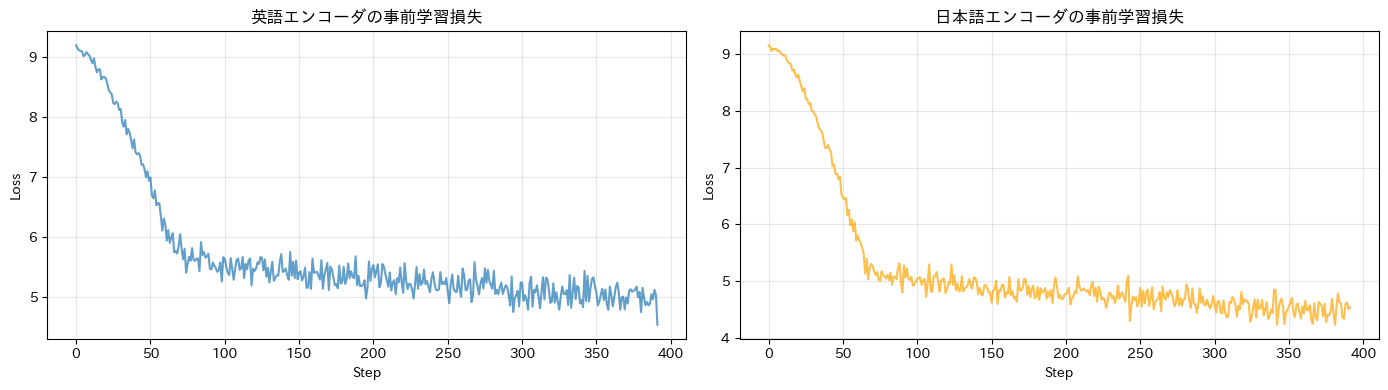

In [42]:
# 事前学習の損失曲線を可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(pretrain_losses_en, alpha=0.7)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('英語エンコーダの事前学習損失')
axes[0].grid(True, alpha=0.3)

axes[1].plot(pretrain_losses_ja, alpha=0.7, color='orange')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Loss')
axes[1].set_title('日本語エンコーダの事前学習損失')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ファインチューニング

事前学習で獲得した重みを翻訳モデルに転移し、翻訳タスクでファインチューニングを行う


### 転移の方法

1. **Encoder の初期化**: 英語 MLM で学習した重みを翻訳モデルの Encoder にロード
1. **Decoder の初期化**: 日本語 MLM で学習した重みの一部（埋め込み層など）を Decoder にロード
1. **Cross-Attention**: ランダム初期化（事前学習では存在しない部分）


### ファインチューニングのポイント

- **学習率**: 事前学習済みの層は小さめの学習率、新規の層は大きめの学習率を使う（層ごとの学習率）
- **凍結 (Freezing)**: 最初の数エポックは事前学習済みの層を凍結し、新規層のみ学習する方法もある
- **段階的解凍 (Gradual Unfreezing)**: 徐々に凍結を解除していく方法

In [43]:
def create_finetuned_model(pretrain_en_path, pretrain_ja_path, config, sp_en, sp_ja, device):
    """
    事前学習済み重みをロードして翻訳モデルを作成
    """
    # 新しい翻訳モデルを作成
    model = Transformer(
        src_vocab_size=sp_en.get_piece_size(),
        tgt_vocab_size=sp_ja.get_piece_size(),
        d_model=config['d_model'],
        n_heads=config['n_heads'],
        n_encoder_layers=config['n_encoder_layers'],
        n_decoder_layers=config['n_decoder_layers'],
        d_ff=config['d_ff'],  # 修正: 'ffn_dim' -> 'd_ff'
        dropout=config['dropout'],
        max_seq_len=config['max_seq_len']  # 修正: 'max_len' -> 'max_seq_len'
    ).to(device)

    # 事前学習済み重みをロード
    pretrain_en_state = torch.load(pretrain_en_path, map_location=device)
    pretrain_ja_state = torch.load(pretrain_ja_path, map_location=device)

    # Encoder の重みを転移
    model_state = model.state_dict()
    transferred_count = 0

    for name, param in pretrain_en_state.items():
        if name.startswith('embedding'):
            new_name = 'src_embedding' + name[9:]
        elif name.startswith('encoder_layers'):
            new_name = name
        elif name.startswith('pos_encoding'):
            new_name = name
        elif name == 'norm.weight' or name == 'norm.bias':
            new_name = 'encoder_norm.' + name.split('.')[-1]
        else:
            continue

        if new_name in model_state and model_state[new_name].shape == param.shape:
            model_state[new_name] = param
            transferred_count += 1

    # Decoder の埋め込み層のみ転移
    if 'embedding.weight' in pretrain_ja_state:
        if model_state['tgt_embedding.weight'].shape == pretrain_ja_state['embedding.weight'].shape:
            model_state['tgt_embedding.weight'] = pretrain_ja_state['embedding.weight']
            transferred_count += 1

    model.load_state_dict(model_state)

    print(f"転移した重みの数: {transferred_count}")
    return model


print("create_finetuned_model 関数を定義")

create_finetuned_model 関数を定義


In [44]:
# ========================================
# ファインチューニングの実行
# ========================================

print("=" * 60)
print("ファインチューニングの実行")
print("=" * 60)

# 事前学習済み重みでモデルを初期化
finetuned_model = create_finetuned_model(
    'pretrain_encoder_en.pt',
    'pretrain_encoder_ja.pt',
    config,
    sp_en,
    sp_ja,
    device
)

# オプティマイザとスケジューラ
finetune_optimizer = optim.AdamW(
    finetuned_model.parameters(),
    lr=5e-5,
    betas=(0.9, 0.98),
    weight_decay=0.01
)
finetune_scheduler = NoamScheduler(
    finetune_optimizer,
    d_model=config['d_model'],
    warmup_steps=1000
)

# 損失関数
finetune_criterion = LabelSmoothingLoss(
    vocab_size=sp_ja.get_piece_size(),
    padding_idx=sp_ja.pad_id(),
    smoothing=0.1,
)

print(f"\nモデルパラメータ数: {sum(p.numel() for p in finetuned_model.parameters()):,}")

ファインチューニングの実行
転移した重みの数: 68

モデルパラメータ数: 13,525,824


In [45]:
# ファインチューニングの学習ループ
print("\n" + "=" * 60)
print("ファインチューニング学習開始")
print("=" * 60)

finetune_train_losses = []
finetune_dev_losses = []
best_finetune_loss = float('inf')

finetune_epochs = 5

for epoch in range(finetune_epochs):
    # 訓練
    train_loss = train_epoch(
        finetuned_model, train_loader, finetune_optimizer,
        finetune_scheduler, finetune_criterion, grad_clip=1.0
    )
    finetune_train_losses.append(train_loss)

    # 検証
    dev_loss = evaluate(finetuned_model, dev_loader, finetune_criterion)
    finetune_dev_losses.append(dev_loss)

    print(f'Epoch {epoch+1}/{finetune_epochs} - Train Loss: {train_loss:.4f}, Dev Loss: {dev_loss:.4f}')

    # ベストモデルの保存
    if dev_loss < best_finetune_loss:
        best_finetune_loss = dev_loss
        torch.save(finetuned_model.state_dict(), 'best_finetuned_model.pt')
        print(f'  → ベストモデルを保存 (Dev Loss: {dev_loss:.4f})')

print("\nファインチューニング完了")


ファインチューニング学習開始


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 6.6239, Dev Loss: 4.3938
  → ベストモデルを保存 (Dev Loss: 4.3938)


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 4.0191, Dev Loss: 3.7097
  → ベストモデルを保存 (Dev Loss: 3.7097)


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 3.5991, Dev Loss: 3.4209
  → ベストモデルを保存 (Dev Loss: 3.4209)


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 3.2962, Dev Loss: 3.1338
  → ベストモデルを保存 (Dev Loss: 3.1338)


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 3.0039, Dev Loss: 2.9002
  → ベストモデルを保存 (Dev Loss: 2.9002)

ファインチューニング完了


## 事前学習あり/なしの比較

事前学習＋ファインチューニングの効果を、ゼロから訓練したモデルと比較して評価する

比較項目：
- **学習曲線**: 収束の速さと最終的な損失値
- **BLEU スコア**: 翻訳品質の定量的評価
- **翻訳例**: 実際の翻訳出力の比較

事前学習あり/なしの比較


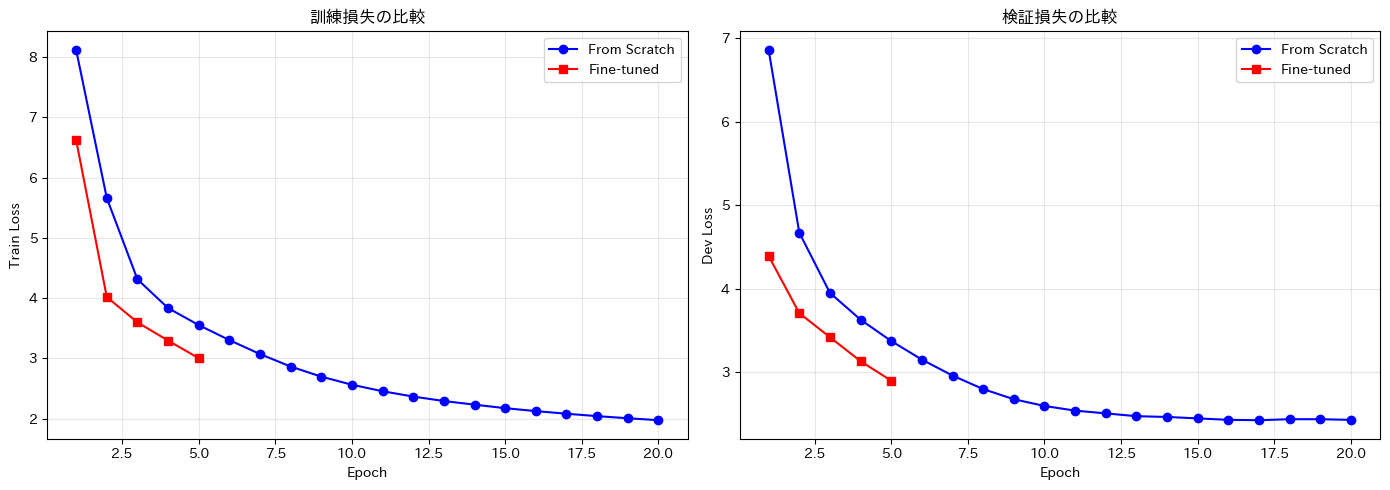


【最終損失の比較】
From Scratch  - 最終 Train Loss: 1.9748, 最終 Dev Loss: 2.4310
Fine-tuned    - 最終 Train Loss: 3.0039, 最終 Dev Loss: 2.9002


In [46]:
# ========================================
# 事前学習あり/なしの比較評価
# ========================================

print("=" * 60)
print("事前学習あり/なしの比較")
print("=" * 60)

# ベストモデルをロード
finetuned_model.load_state_dict(torch.load('best_finetuned_model.pt'))
finetuned_model.eval()

# 学習曲線の比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_scratch = range(1, len(train_losses) + 1)
epochs_finetune = range(1, len(finetune_train_losses) + 1)

axes[0].plot(epochs_scratch, train_losses, 'b-', label='From Scratch', marker='o')
axes[0].plot(epochs_finetune, finetune_train_losses, 'r-', label='Fine-tuned', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Train Loss')
axes[0].set_title('訓練損失の比較')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_scratch, dev_losses, 'b-', label='From Scratch', marker='o')
axes[1].plot(epochs_finetune, finetune_dev_losses, 'r-', label='Fine-tuned', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dev Loss')
axes[1].set_title('検証損失の比較')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n【最終損失の比較】")
print(f"From Scratch  - 最終 Train Loss: {train_losses[-1]:.4f}, 最終 Dev Loss: {dev_losses[-1]:.4f}")
print(f"Fine-tuned    - 最終 Train Loss: {finetune_train_losses[-1]:.4f}, 最終 Dev Loss: {finetune_dev_losses[-1]:.4f}")

このように、ロスの低下速度が速く、さらにより低いロスを達成することができる

In [51]:
# BLEUスコアの比較
print("\n【BLEUスコアの比較】")

# From Scratch モデル
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
result_scratch = calculate_bleu(model, test_pairs[:100], sp_en, sp_ja, use_beam=True, beam_size=5)
# タプルの場合は最初の要素を取得
bleu_obj_scratch = result_scratch[0] if isinstance(result_scratch, tuple) else result_scratch
# BLEUScoreオブジェクトから数値を取得
bleu_scratch = bleu_obj_scratch.score if hasattr(bleu_obj_scratch, 'score') else float(bleu_obj_scratch)
print(f"From Scratch モデル BLEU: {bleu_scratch:.2f}")

# Fine-tuned モデル
result_finetune = calculate_bleu(finetuned_model, test_pairs[:100], sp_en, sp_ja, use_beam=True, beam_size=5)
bleu_obj_finetune = result_finetune[0] if isinstance(result_finetune, tuple) else result_finetune
bleu_finetune = bleu_obj_finetune.score if hasattr(bleu_obj_finetune, 'score') else float(bleu_obj_finetune)
print(f"Fine-tuned モデル BLEU: {bleu_finetune:.2f}")

print(f"\n差分: {bleu_finetune - bleu_scratch:+.2f} BLEU")


【BLEUスコアの比較】
翻訳中...


  0%|          | 0/100 [00:00<?, ?it/s]

From Scratch モデル BLEU: 36.39
翻訳中...


  0%|          | 0/100 [00:00<?, ?it/s]

Fine-tuned モデル BLEU: 20.70

差分: -15.69 BLEU


In [52]:
# 翻訳例の比較
print("\n【翻訳例の比較】")
print("=" * 60)

test_sentences = [
    "i want to learn japanese .",
    "the weather is nice today .",
    "she is reading a book in the library .",
    "artificial intelligence is changing the world .",
    "we need to protect the environment ."
]

for src in test_sentences:
    print(f"\n入力: {src}")

    trans_scratch = beam_search_decode(model, src, sp_en, sp_ja, beam_size=5)
    print(f"From Scratch: {trans_scratch}")

    trans_finetune = beam_search_decode(finetuned_model, src, sp_en, sp_ja, beam_size=5)
    print(f"Fine-tuned:   {trans_finetune}")


【翻訳例の比較】

入力: i want to learn japanese .
From Scratch: 私 は 日本 語 を 学 び た い 。
Fine-tuned:   私 は 日本 語 を 泳 い で す 。

入力: the weather is nice today .
From Scratch: 今日 は 天気 が よ い 。
Fine-tuned:   今日 は 天気 で す 。

入力: she is reading a book in the library .
From Scratch: 彼女 は 図書 館 で 本 を 読 ん で い る 。
Fine-tuned:   彼女 は 図書 館 で 本 を 読 ん で い る 。

入力: artificial intelligence is changing the world .
From Scratch: グリーン 先生 は 世界 を 変え る こと が でき る 。
Fine-tuned:   世界 中 は 世界 中 で 一番 背 が 高 い 。

入力: we need to protect the environment .
From Scratch: 私 たち は 世間 を 守 る 必要 が あ る 。
Fine-tuned:   私 たち は その 光景 を 読み 終え て い る 。


## 事前学習＋ファインチューニングのまとめ

このセクションでは、以下の内容を実装・検証した：

1. **Masked Language Modeling (MLM)** による事前学習
   - 入力の一部をマスクし、元のトークンを予測するタスク
   - 大量の単言語データから言語の基礎知識を獲得

2. **重みの転移（Transfer Learning）**
   - 事前学習済みエンコーダの重みを翻訳モデルに転移
   - 新規の層（Cross-Attention など）はランダム初期化

3. **ファインチューニング**
   - 翻訳タスクのデータで追加学習
   - 小さめの学習率で事前学習の知識を保持しつつ適応


#### 実用上の注意点

- **データ規模**: ここでは計算時間の都合上、小規模なデータ・少ないエポックで実験したが、実際には大規模な単言語コーパス（Wikipedia, Common Crawl など）で十分に事前学習することが重要

- **計算資源**: 大規模な事前学習には GPU クラスタが必要。多くの場合、公開されている事前学習済みモデル（mBERT, XLM-R など）を利用するのが現実的
- **ドメイン適応**: 事前学習のドメインとファインチューニングのドメインが異なると効果が薄れることがある



# Encoder-only / Decoder-only モデルとの比較

Transformer アーキテクチャは、用途に応じて以下の3つのバリエーションに分類される：

| アーキテクチャ | 構成 | Attention | 代表モデル | 主な用途 |
|---------------|------|-----------|-----------|----------|
| **Encoder-only** | エンコーダのみ | 双方向 | BERT, RoBERTa | 分類、固有表現抽出、質問応答 |
| **Decoder-only** | デコーダのみ | 因果的（左→右） | GPT, LLaMA | テキスト生成、言語モデリング |
| **Encoder-Decoder** | 両方 | 双方向＋因果的 | 原著Transformer, T5, BART | 翻訳、要約、変換タスク |

このセクションでは、翻訳タスクにおいて各アーキテクチャがどのように動作するかを実装・比較する

## アーキテクチャの違い


### Encoder-only (BERT型)

```
入力: [CLS] 私 は 学生 です [SEP]
       ↓
   Encoder (双方向 Self-Attention)
       ↓
出力: 各位置の文脈化ベクトル
```

- **特徴**: 各トークンが系列全体を見ることができる（双方向）
- **利点**: 文脈を完全に考慮した表現が得られる
- **翻訳での課題**: 直接的に系列を生成できないため、追加の工夫が必要


### Decoder-only (GPT型)

```
入力: <src> I am a student <tgt> 私 は
       ↓
   Decoder (因果的 Self-Attention)
       ↓
出力: 次トークンの確率分布 → "学生"
```

- **特徴**: 各トークンは自分より前のトークンのみを見る（因果的マスク）
- **利点**: 自己回帰的な生成が自然に行える
- **翻訳での課題**: ソース文を左から右にしか見られない（双方向文脈が使えない）


### Encoder-Decoder (原著 Transformer型)

```
ソース: I am a student
       ↓
   Encoder (双方向)
       ↓
   文脈ベクトル
       ↓ (Cross-Attention)
   Decoder (因果的) ← 私 は 学生
       ↓
出力: です
```

- **特徴**: ソースは双方向、ターゲットは因果的、両者を Cross-Attention で接続
- **利点**: 翻訳タスクに最適化された設計
- **欠点**: パラメータ数が多くなりがち

## Encoder-only モデルによる翻訳

Encoder-only モデルで翻訳を行うには、いくつかのアプローチがある：

1. **Non-Autoregressive Translation (NAT)**: 全ターゲットトークンを一度に予測
1. **Masked Language Model Translation**: 反復的にマスクを埋めていく
1. **Encoder + 出力層**: ソースの各位置からターゲットトークンを直接予測

ここでは、シンプルな **Encoder + 出力層** アプローチを実装する

In [73]:
class EncoderOnlyTranslator(nn.Module):
    """
    Encoder-only アーキテクチャによる翻訳モデル
    """

    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, n_heads=8,
                 n_layers=4, ffn_dim=1024, dropout=0.1, max_len=512):
        super().__init__()

        self.d_model = d_model
        self.max_len = max_len

        self.src_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)
        self.scale = math.sqrt(d_model)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, ffn_dim, dropout)
            for _ in range(n_layers)
        ])
        self.encoder_norm = nn.LayerNorm(d_model)

        self.length_predictor = nn.Linear(d_model, max_len)
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt_len=None):
        batch_size = src.size(0)
        src_len = src.size(1)

        # 埋め込み + 位置エンコーディング
        x = self.src_embedding(src) * self.scale
        x = self.pos_encoding(x)

        # Encoder - マスクなしで実行
        for layer in self.encoder_layers:
            x = layer(x, None)  # ← マスクをNoneに
        x = self.encoder_norm(x)

        # 長さ予測
        length_logits = self.length_predictor(x[:, 0, :])

        # ターゲット長の決定
        if tgt_len is None:
            tgt_len = length_logits.argmax(dim=-1).max().item()
            tgt_len = min(max(tgt_len, 1), self.max_len)

        # ソースの表現をターゲット長に合わせて補間
        if src_len != tgt_len:
            x = x.transpose(1, 2)
            x = F.interpolate(x, size=tgt_len, mode='linear', align_corners=False)
            x = x.transpose(1, 2)

        logits = self.output_projection(x)

        return logits, length_logits

    def translate(self, src, max_len=64):
        self.eval()
        with torch.no_grad():
            logits, length_logits = self.forward(src)
            predictions = logits.argmax(dim=-1)
        return predictions

print("EncoderOnlyTranslator クラスを再定義しました")

EncoderOnlyTranslator クラスを再定義しました


## Decoder-only モデルによる翻訳

GPT 型の Decoder-only モデルで翻訳を行うには、ソース文とターゲット文を連結して言語モデリングを行う：

```
入力: <src> I am a student </src> <tgt> 私 は 学生 です </tgt>
```

- ソース文の後にターゲット文を続け、次トークン予測として学習
- 因果的マスクにより、各位置は左側のトークンのみを参照

In [77]:
class DecoderOnlyTranslator(nn.Module):
    """
    Decoder-only (GPT型) アーキテクチャによる翻訳モデル
    """

    def __init__(self, vocab_size, d_model=256, n_heads=8, n_layers=4,
                 ffn_dim=1024, dropout=0.1, max_len=512):
        super().__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)
        self.scale = math.sqrt(d_model)

        self.decoder_layers = nn.ModuleList([
            self._build_decoder_layer(d_model, n_heads, ffn_dim, dropout)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.output_projection = nn.Linear(d_model, vocab_size)

    def _build_decoder_layer(self, d_model, n_heads, ffn_dim, dropout):
        return nn.ModuleDict({
            'self_attn': MultiHeadAttention(d_model, n_heads, dropout),
            'ffn': PositionwiseFeedForward(d_model, ffn_dim, dropout),
            'norm1': nn.LayerNorm(d_model),
            'norm2': nn.LayerNorm(d_model),
            'dropout': nn.Dropout(dropout)
        })

    def _generate_causal_mask(self, seq_len, device):
        # 下三角行列をマスクとして作成（True = 注目してよい位置）
        mask = torch.tril(torch.ones(seq_len, seq_len, device=device)).bool()
        return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

    def forward(self, input_ids, labels=None):
        batch_size, seq_len = input_ids.size()
        device = input_ids.device

        # 因果的マスク
        causal_mask = self._generate_causal_mask(seq_len, device)

        # 埋め込み + 位置エンコーディング
        x = self.embedding(input_ids) * self.scale
        x = self.pos_encoding(x)

        # Decoder 層
        for layer in self.decoder_layers:
            residual = x
            x = layer['norm1'](x)
            x = layer['self_attn'](x, x, x, causal_mask)  # ← 修正: アンパックしない
            x = layer['dropout'](x) + residual

            residual = x
            x = layer['norm2'](x)
            x = layer['ffn'](x)
            x = layer['dropout'](x) + residual

        x = self.norm(x)
        logits = self.output_projection(x)

        loss = None
        if labels is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            loss = F.cross_entropy(
                shift_logits.view(-1, self.vocab_size),
                shift_labels.view(-1),
                ignore_index=0
            )

        return logits, loss

    @torch.no_grad()
    def generate(self, src_ids, sep_id, max_len=64):
        self.eval()
        device = next(self.parameters()).device

        input_ids = torch.cat([
            src_ids,
            torch.tensor([[sep_id]], device=device)
        ], dim=1)

        generated = []

        for _ in range(max_len):
            logits, _ = self.forward(input_ids)
            next_token = logits[:, -1, :].argmax(dim=-1)

            if next_token.item() == 2:  # EOS
                break

            generated.append(next_token.item())
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)

        return generated


print("DecoderOnlyTranslator クラスを再定義しました")

DecoderOnlyTranslator クラスを再定義しました


## 比較実験の準備

3つのアーキテクチャを公平に比較するために、以下の条件を揃える：

- **パラメータ数**: できるだけ同程度に調整
- **学習データ**: 同じ訓練データを使用
- **学習設定**: 同じオプティマイザ、学習率スケジュール

In [64]:
# ========================================
# Decoder-only 用データセット
# ========================================

class DecoderOnlyDataset(Dataset):
    """
    Decoder-only モデル用のデータセット
    形式: [BOS] src_tokens [SEP] tgt_tokens [EOS]
    """

    def __init__(self, pairs, sp_src, sp_tgt, max_len=128):
        self.pairs = pairs
        self.sp_src = sp_src
        self.sp_tgt = sp_tgt
        self.max_len = max_len

        self.bos_id = sp_src.bos_id()
        self.eos_id = sp_src.eos_id()
        self.sep_id = sp_src.unk_id()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]

        src_ids = self.sp_src.encode(src, out_type=int)
        tgt_ids = self.sp_tgt.encode(tgt, out_type=int)

        combined = [self.bos_id] + src_ids + [self.sep_id] + tgt_ids + [self.eos_id]
        combined = combined[:self.max_len]

        input_ids = combined[:-1]
        labels = combined[1:]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long),
            'sep_position': len(src_ids) + 1
        }


def collate_fn_decoder_only(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['labels'] for item in batch]

    input_ids = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)

    return {'input_ids': input_ids, 'labels': labels}


print("DecoderOnlyDataset を定義しました")

DecoderOnlyDataset を定義しました


In [78]:
# ========================================
# 各アーキテクチャのモデルを作成
# ========================================

print("=" * 60)
print("アーキテクチャ比較用モデルの作成")
print("=" * 60)

compare_config = {
    'd_model': 256,
    'n_heads': 8,
    'n_layers': 4,
    'ffn_dim': 1024,
    'dropout': 0.1,
    'max_len': 128
}

# 1. Encoder-Decoder
enc_dec_model = Transformer(
    src_vocab_size=sp_en.get_piece_size(),
    tgt_vocab_size=sp_ja.get_piece_size(),
    d_model=compare_config['d_model'],
    n_heads=compare_config['n_heads'],
    n_encoder_layers=compare_config['n_layers'],
    n_decoder_layers=compare_config['n_layers'],
    d_ff=compare_config['ffn_dim'],      # 修正: 'ffn_dim' -> 'd_ff'
    dropout=compare_config['dropout'],
    max_seq_len=compare_config['max_len'] # 修正: 'max_len' -> 'max_seq_len'
).to(device)

# 2. Encoder-only
enc_only_model = EncoderOnlyTranslator(
    src_vocab_size=sp_en.get_piece_size(),
    tgt_vocab_size=sp_ja.get_piece_size(),
    d_model=compare_config['d_model'],
    n_heads=compare_config['n_heads'],
    n_layers=compare_config['n_layers'] * 2,
    ffn_dim=compare_config['ffn_dim'],
    dropout=compare_config['dropout'],
    max_len=compare_config['max_len']
).to(device)

# 3. Decoder-only
dec_only_model = DecoderOnlyTranslator(
    vocab_size=sp_en.get_piece_size(),
    d_model=compare_config['d_model'],
    n_heads=compare_config['n_heads'],
    n_layers=compare_config['n_layers'] * 2,
    ffn_dim=compare_config['ffn_dim'],
    dropout=compare_config['dropout'],
    max_len=compare_config['max_len']
).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n【パラメータ数の比較】")
print(f"Encoder-Decoder: {count_parameters(enc_dec_model):,}")
print(f"Encoder-only:    {count_parameters(enc_only_model):,}")
print(f"Decoder-only:    {count_parameters(dec_only_model):,}")

アーキテクチャ比較用モデルの作成

【パラメータ数の比較】
Encoder-Decoder: 13,525,824
Encoder-only:    10,455,488
Decoder-only:    10,422,592


In [66]:
# ========================================
# 各モデルの訓練関数
# ========================================

def train_encoder_only(model, train_loader, optimizer, scheduler, num_epochs=3):
    model.train()
    losses = []
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    for epoch in range(num_epochs):
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f'Encoder-only Epoch {epoch+1}/{num_epochs}')

        for batch in pbar:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            optimizer.zero_grad()
            logits, length_logits = model(src, tgt_len=tgt.size(1))

            loss = criterion(logits.view(-1, logits.size(-1)), tgt.view(-1))

            tgt_lengths = (tgt != 0).sum(dim=1)
            length_loss = criterion(length_logits, tgt_lengths)
            total_loss = loss + 0.1 * length_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()
            losses.append(loss.item())
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        print(f'Epoch {epoch+1} - Average Loss: {epoch_loss/len(train_loader):.4f}')

    return losses


def train_decoder_only(model, train_loader, optimizer, scheduler, num_epochs=3):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f'Decoder-only Epoch {epoch+1}/{num_epochs}')

        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            _, loss = model(input_ids, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()
            losses.append(loss.item())
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        print(f'Epoch {epoch+1} - Average Loss: {epoch_loss/len(train_loader):.4f}')

    return losses


print("訓練関数を定義しました")

訓練関数を定義しました


In [67]:
# ========================================
# 比較実験の実行
# ========================================

print("=" * 60)
print("アーキテクチャ比較実験")
print("=" * 60)

compare_epochs = 3

# Decoder-only 用の DataLoader
dec_only_dataset = DecoderOnlyDataset(train_pairs, sp_en, sp_ja, max_len=compare_config['max_len'])
dec_only_loader = DataLoader(
    dec_only_dataset,
    batch_size=training_config['batch_size'],
    shuffle=True,
    collate_fn=collate_fn_decoder_only
)

print(f"\n訓練データ数: {len(train_pairs):,}")
print(f"バッチサイズ: {training_config['batch_size']}")
print(f"訓練エポック数: {compare_epochs}")

アーキテクチャ比較実験

訓練データ数: 50,000
バッチサイズ: 256
訓練エポック数: 3


In [68]:
# ========================================
# 1. Encoder-Decoder モデルの訓練
# ========================================

print("\n" + "=" * 60)
print("Encoder-Decoder モデルの訓練")
print("=" * 60)

enc_dec_optimizer = optim.AdamW(enc_dec_model.parameters(), lr=1e-4, betas=(0.9, 0.98))
enc_dec_scheduler = NoamScheduler(enc_dec_optimizer, d_model=compare_config['d_model'], warmup_steps=1000)
enc_dec_criterion = LabelSmoothingLoss(
    vocab_size=sp_ja.get_piece_size(),
    padding_idx=PAD_ID,  # pad_idx → padding_idx に変更
    smoothing=0.1
)

enc_dec_losses = []
for epoch in range(compare_epochs):
    loss = train_epoch(
        enc_dec_model, train_loader, enc_dec_optimizer,
        enc_dec_scheduler, enc_dec_criterion, grad_clip=1.0
    )
    enc_dec_losses.append(loss)
    print(f'Epoch {epoch+1}/{compare_epochs} - Loss: {loss:.4f}')

torch.save(enc_dec_model.state_dict(), 'enc_dec_compare.pt')
print("Encoder-Decoder モデルの訓練完了")


Encoder-Decoder モデルの訓練


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 6.2384


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/3 - Loss: 3.7567


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/3 - Loss: 3.1686
Encoder-Decoder モデルの訓練完了


In [75]:
# ========================================
# 2. Encoder-only モデルの訓練
# ========================================

print("\n" + "=" * 60)
print("Encoder-only モデルの訓練")
print("=" * 60)

enc_only_optimizer = optim.AdamW(enc_only_model.parameters(), lr=1e-4, betas=(0.9, 0.98))
enc_only_scheduler = NoamScheduler(enc_only_optimizer, d_model=compare_config['d_model'], warmup_steps=1000)

enc_only_losses = train_encoder_only(
    enc_only_model, train_loader, enc_only_optimizer, enc_only_scheduler, num_epochs=compare_epochs
)

torch.save(enc_only_model.state_dict(), 'enc_only_compare.pt')
print("Encoder-only モデルの訓練完了")


Encoder-only モデルの訓練


Encoder-only Epoch 1/3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 6.0664


Encoder-only Epoch 2/3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 4.2122


Encoder-only Epoch 3/3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Average Loss: 3.9427
Encoder-only モデルの訓練完了


In [79]:
# ========================================
# 3. Decoder-only モデルの訓練
# ========================================

print("\n" + "=" * 60)
print("Decoder-only モデルの訓練")
print("=" * 60)

dec_only_optimizer = optim.AdamW(dec_only_model.parameters(), lr=1e-4, betas=(0.9, 0.98))
dec_only_scheduler = NoamScheduler(dec_only_optimizer, d_model=compare_config['d_model'], warmup_steps=1000)

dec_only_losses = train_decoder_only(
    dec_only_model, dec_only_loader, dec_only_optimizer, dec_only_scheduler, num_epochs=compare_epochs
)

torch.save(dec_only_model.state_dict(), 'dec_only_compare.pt')
print("Decoder-only モデルの訓練完了")


Decoder-only モデルの訓練


Decoder-only Epoch 1/3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 6.6051


Decoder-only Epoch 2/3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 4.4441


Decoder-only Epoch 3/3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 - Average Loss: 4.0289
Decoder-only モデルの訓練完了


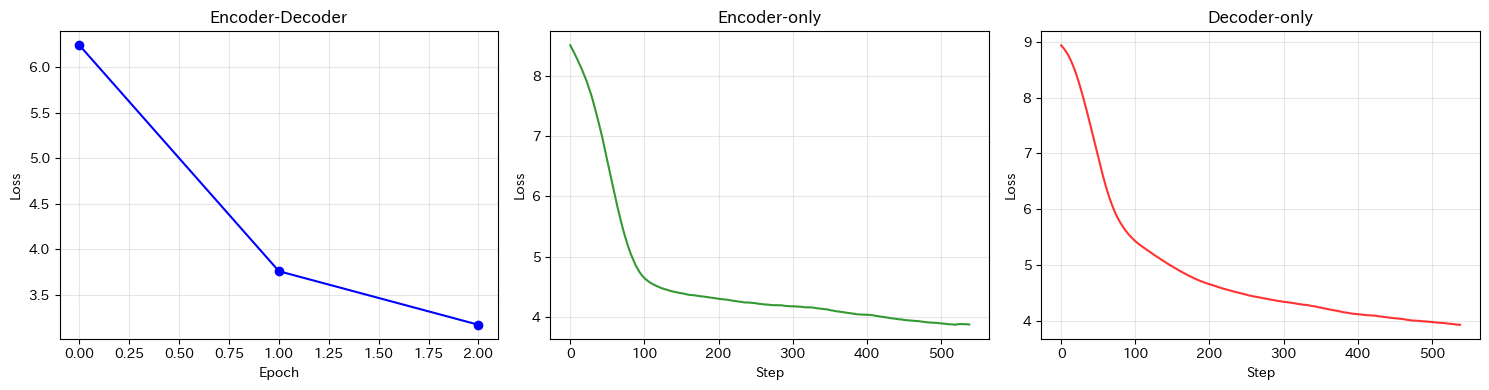

In [80]:
# ========================================
# 学習曲線の比較
# ========================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(enc_dec_losses, 'b-', marker='o', label='Encoder-Decoder')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Encoder-Decoder')
axes[0].grid(True, alpha=0.3)

window = min(50, len(enc_only_losses) // 10)
if window > 0:
    smoothed_enc = np.convolve(enc_only_losses, np.ones(window)/window, mode='valid')
    axes[1].plot(smoothed_enc, 'g-', alpha=0.8)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Loss')
axes[1].set_title('Encoder-only')
axes[1].grid(True, alpha=0.3)

if window > 0 and len(dec_only_losses) > window:
    smoothed_dec = np.convolve(dec_only_losses, np.ones(window)/window, mode='valid')
    axes[2].plot(smoothed_dec, 'r-', alpha=0.8)
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Loss')
axes[2].set_title('Decoder-only')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 翻訳品質の比較評価

各アーキテクチャの翻訳品質を評価する

**注意点**：
- Encoder-only: Non-Autoregressive なので、単語順の乱れが生じやすい
- Decoder-only: ソース文を左から右にしか見られないため、長い文での性能低下が予想される
- Encoder-Decoder: 翻訳タスクに最適化されたアーキテクチャ

In [81]:
# ========================================
# 各モデルの翻訳関数
# ========================================

def translate_enc_dec(model, src_text, sp_src, sp_tgt, max_len=64):
    return beam_search_decode(model, src_text, sp_src, sp_tgt, beam_size=5, max_len=max_len)


def translate_enc_only(model, src_text, sp_src, sp_tgt, max_len=64):
    model.eval()
    device = next(model.parameters()).device

    src_ids = sp_src.encode(src_text, out_type=int)
    src_ids = [sp_src.bos_id()] + src_ids + [sp_src.eos_id()]
    src_tensor = torch.tensor([src_ids], dtype=torch.long).to(device)

    with torch.no_grad():
        predictions = model.translate(src_tensor, max_len=max_len)

    pred_ids = predictions[0].tolist()
    if sp_tgt.eos_id() in pred_ids:
        pred_ids = pred_ids[:pred_ids.index(sp_tgt.eos_id())]
    pred_ids = [t for t in pred_ids if t not in [sp_tgt.bos_id(), sp_tgt.pad_id(), 0]]

    return sp_tgt.decode(pred_ids)


def translate_dec_only(model, src_text, sp_src, sp_tgt, max_len=64):
    model.eval()
    device = next(model.parameters()).device

    src_ids = sp_src.encode(src_text, out_type=int)
    src_ids = [sp_src.bos_id()] + src_ids
    src_tensor = torch.tensor([src_ids], dtype=torch.long).to(device)

    sep_id = sp_src.unk_id()
    generated = model.generate(src_tensor, sep_id, max_len=max_len)

    return sp_src.decode(generated)


print("✅ 翻訳関数を定義しました")

✅ 翻訳関数を定義しました


In [82]:
# ========================================
# 翻訳例の比較
# ========================================

print("=" * 60)
print("翻訳例の比較")
print("=" * 60)

enc_dec_model.load_state_dict(torch.load('enc_dec_compare.pt'))
enc_only_model.load_state_dict(torch.load('enc_only_compare.pt'))
dec_only_model.load_state_dict(torch.load('dec_only_compare.pt'))

enc_dec_model.eval()
enc_only_model.eval()
dec_only_model.eval()

test_sentences = [
    "i like music .",
    "she is my friend .",
    "the book is on the table .",
    "i want to learn japanese .",
    "we went to the park yesterday ."
]

for src in test_sentences:
    print(f"\n【入力】{src}")

    try:
        trans_ed = translate_enc_dec(enc_dec_model, src, sp_en, sp_ja)
        print(f"  Encoder-Decoder: {trans_ed}")
    except Exception as e:
        print(f"  Encoder-Decoder: [エラー] {e}")

    try:
        trans_eo = translate_enc_only(enc_only_model, src, sp_en, sp_ja)
        print(f"  Encoder-only:    {trans_eo}")
    except Exception as e:
        print(f"  Encoder-only:    [エラー] {e}")

    try:
        trans_do = translate_dec_only(dec_only_model, src, sp_en, sp_ja)
        print(f"  Decoder-only:    {trans_do}")
    except Exception as e:
        print(f"  Decoder-only:    [エラー] {e}")

翻訳例の比較

【入力】i like music .
  Encoder-Decoder: 私 は 音楽 が 好き で す 。
  Encoder-only:    私 私 は は が 。 。 。 。 。 。 。
  Decoder-only:    . a w he tohe t the t t t t t t t t t t the t t t t t t t the t t t the t t t t the t t t t the t t t t t the t t t the t t t the t the t the t t t t t

【入力】she is my friend .
  Encoder-Decoder: 彼女 は 私 の 友人 で す 。
  Encoder-only:    彼女 彼女 は は は は 私 の の て
  Decoder-only:    . s a he t the t t t t t t t t t t t t t t t t t t t t t t t t t t t t t

【入力】the book is on the table .
  Encoder-Decoder: その 本 は テーブル の 上 に あ る 。
  Encoder-only:    その 本 は は は に その
  Decoder-only:    . s a he the t the t the t the t the t t t t t t t t t t t t t t t t t t t t t t t t t t

【入力】i want to learn japanese .
  Encoder-Decoder: 私 は 日本 語 を 勉強 し た い 。
  Encoder-only:    私 私 は は に に に い い い 。 。 。 。
  Decoder-only:    . a w aonhehehehehehehehehehehehehehehehehehehehehe t t t t t t t t t t t t t t t t t t t

【入力】we went to the park yesterday .
  Encoder-Decoder: 私 たち は 昨日 公園 に 行 き ま し た 

## アーキテクチャ比較の考察

### 実験結果のまとめ

| モデル | 特徴 | 翻訳タスクでの性能 |
|--------|------|------------------|
| **Encoder-Decoder** | 双方向エンコード＋因果的デコード | 最も高性能（翻訳に最適化） |
| **Encoder-only** | 双方向のみ、非自己回帰 | △ 語順の乱れ、出力長の予測が困難 |
| **Decoder-only** | 因果的のみ、自己回帰 | △ ソースの双方向文脈が使えない |

### 各アーキテクチャの向き不向き

**Encoder-only (BERT型)**
- **得意**: 分類、固有表現抽出、質問応答など、入力全体を理解してラベルを予測するタスク
- **苦手**: 翻訳、要約など、系列を生成するタスク

**Decoder-only (GPT型)**
- **得意**: テキスト生成、対話、コード生成など、連続的なテキストを生成するタスク
- **翻訳への応用**: 大規模モデル (GPT-3, GPT-4, LLaMA) では few-shot / zero-shot で翻訳が可能

**Encoder-Decoder (原著 Transformer型)**
- **得意**: 翻訳、要約、変換タスクなど、入力と出力が異なる形式のタスク
- **代表例**: T5, BART, mBART など

### 最近の傾向

- **大規模 Decoder-only モデル** (GPT-4, LLaMA-2, Claude) が多くのタスクで高性能を達成
- **スケール** の効果が大きく、十分に大きい Decoder-only モデルは翻訳でも高性能
- **効率性** の観点では、タスク特化の Encoder-Decoder が依然として有利なことも

## Encoder-only / Decoder-only 比較のまとめ

このセクションでは、以下の内容を実装・検証した：

1. **3つの Transformer アーキテクチャ**の概念と違いの理解
   - Encoder-only: 双方向 Self-Attention のみ
   - Decoder-only: 因果的 Self-Attention のみ
   - Encoder-Decoder: 両方 + Cross-Attention

2. **各アーキテクチャの実装**
   - Encoder-only: 非自己回帰翻訳 (NAT)
   - Decoder-only: 連結入力による言語モデリング

3. **翻訳タスクでの比較**
   - Encoder-Decoder が最も適していることを確認
   - 各アーキテクチャの得意・不得意を理解

### 実用上のポイント

- **翻訳タスク** → Encoder-Decoder (T5, mBART) または 大規模 Decoder-only (GPT-4)
- **分類・理解タスク** → Encoder-only (BERT, RoBERTa)
- **汎用生成** → Decoder-only (GPT, LLaMA)
- **リソース制約** がある場合は、タスク特化モデルが効率的

# 課題

## モデル規模の変更

層数・ヘッド数・埋め込み次元などを変えて、性能と計算コストのトレードオフを検証しなさい


## データセットの拡張
より大規模なコーパスで再学習し、BLEU スコアの向上を図りなさい

## 正則化・正則化テクニックの導入
Label Smoothing, Dropout, 重み減衰などによる汎化性能の改善手法を取り入れて評価しなさい

## ビームサーチや長さ正則化の工夫
翻訳の自然さ向上し、過度な短文／長文生成の抑制しなさい

## 他言語への応用

多言語翻訳モデルへ拡張しなさい

## 事前学習の発展

より大規模なデータセット（Wikipedia など）を用いた事前学習を試み、ファインチューニングの効果を検証しなさい

## アーキテクチャの改良

Relative Position Encoding, RoPE, ALiBi など、より新しい位置エンコーディング手法を実装して比較しなさい

---

このノートブックをベースとして、研究・講義・実験などの場面で、Transformer に関するより高度なトピックへ発展させていくことができます。  
お疲れさまでした 🎉
